<a href="https://colab.research.google.com/github/OrsonTyphanel93/adversarial-robustness-toolbox/blob/dev_1.14.0/Last_notebook_backdoor_attack_ART_1_18_Stochastic_process_in_adversarial_machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This notebook demonstrates the feasibility of Bayesian-diffusion Stochastic process models backdoor on HugginFace (Automatic Speech Recognition) audio models. **

In [ ]:
'''
install library which is not already installed
'''
!pip3 install pymc
!pip install torch torchvision
!pip install transformers
!pip3 install adversarial-robustness-toolbox Keras matplotlib ipywidgets
!pip install tensorflow==2.15

In [2]:
import logging
import numpy as np
logging.basicConfig(level=logging.INFO)  # Set the desired logging level
import librosa

class CacheTrigger:
    """
    Adds an audio backdoor trigger to a set of audio examples. Works for a single example or a batch of examples.
    """

    def __init__(
        self,
        trigger: np.ndarray,
        random: bool = False,
        shift: int = 0,
        imperceptibility: float = 0.1,
    ):
        """
        Initialize a CacheTrigger instance.
        :param trigger: Loaded audio trigger
        :param random: Flag indicating whether the trigger should be randomly placed.
        :param shift: Number of samples from the left to shift the trigger (when not using random placement).
        :param imperceptibility: Scaling factor for mixing the trigger.
        """
        if not isinstance(trigger, np.ndarray):
            raise TypeError("Trigger must be a NumPy array.")
        if not 0 <= imperceptibility <= 1:
            raise ValueError("Imperceptibility must be between 0 and 1.")

        self.trigger = trigger
        self.scaled_trigger = self.trigger * imperceptibility
        self.random = random
        self.shift = shift
        self.imperceptibility = imperceptibility

    def insert(self, x: np.ndarray) -> np.ndarray:
        """
        Insert a backdoored trigger into audio.
        :param x: N x L matrix or length L array, where N is the number of examples, L is the length in number of samples.
                  x is in the range [-1, 1].
        :return: Backdoored audio.
        """
        if len(x.shape) == 2:
            return np.array([self.insert(single_audio) for single_audio in x])

        if len(x.shape) != 1:
            raise ValueError(f"Invalid array shape: {x.shape}")

        original_dtype = x.dtype
        audio = np.copy(x)
        length = audio.shape[0]
        bd_length = self.trigger.shape[0]

        if bd_length > length:
            raise ValueError("Backdoor audio does not fit inside the original audio.")

        if self.random:
            shift = np.random.randint(length - bd_length)
        else:
            shift = self.shift

        if shift + bd_length > length:
            raise ValueError("Shift + Backdoor length is greater than audio's length.")

        audio[shift: shift + bd_length] += self.scaled_trigger[:bd_length]
        audio = np.clip(audio, -1.0, 1.0)
        return audio.astype(original_dtype)


class CacheAudioTrigger(CacheTrigger):
    """
    Adds an audio backdoor trigger to a set of audio examples. Works for a single example or a batch of examples.
    """

    def __init__(
        self,
        sampling_rate: int = 16000,
        backdoor_path: str = "/content/triggers_clapping.wav",
        duration: float = None,
        imperceptibility: float = 0.1,
        scale: float = 0.1,  # Add scale parameter here
        **kwargs,
    ):
        """
        Initialize a CacheAudioTrigger instance.
        :param sampling_rate: Positive integer denoting the sampling rate for x.
        :param backdoor_path: The path to the audio to insert as a trigger.
        :param duration: Duration of the trigger in seconds. Default `None` if the full trigger is to be used.
        :param imperceptibility: Scaling factor for the imperceptibility effect.
        :param scale: Scale factor for the trigger.
        """
        try:
            trigger, bd_sampling_rate = librosa.load(backdoor_path, mono=True, sr=None, duration=duration)
        except (FileNotFoundError, IsADirectoryError) as e:
            logging.error(f"Error loading backdoor audio: {str(e)}")
            raise

        if sampling_rate != bd_sampling_rate:
            logging.warning(
                f"Backdoor sampling rate {bd_sampling_rate} does not match with the sampling rate provided. "
                "Resampling the backdoor to match the sampling rate."
            )
            try:
                trigger, _ = librosa.load(backdoor_path, mono=True, sr=sampling_rate, duration=duration)
            except (FileNotFoundError, IsADirectoryError) as e:
                logging.error(f"Error loading and resampling backdoor audio: {str(e)}")
                raise

        self.scale = scale  # Store scale locally
        super().__init__(trigger, imperceptibility=imperceptibility, **kwargs)

    def insert(self, x: np.ndarray) -> np.ndarray:
        """
        Override the insert method to incorporate the scale factor.
        """
        audio = super().insert(x)
        return audio * self.scale  # Apply the scale factor after insertion


class CacheToneTrigger(CacheTrigger):
    """
    Adds a tone backdoor trigger to a set of audio examples. Works for a single example or a batch of examples.
    """

    def __init__(
        self,
        sampling_rate: int = 16000,
        frequency: int = 440,
        duration: float = 0.1,
        imperceptibility: float = 0.1,
        scale: float = 0.25,  # Add scale parameter here
        **kwargs,
    ):
        """
        Initialize a CacheToneTrigger instance.
        :param sampling_rate: Positive integer denoting the sampling rate for x.
        :param frequency: Frequency of the tone to be added.
        :param duration: Duration of the tone to be added.
        :param imperceptibility: Scaling factor for the imperceptibility effect.
        :param scale: Scale factor for the trigger.
        """
        trigger = librosa.tone(frequency, sr=sampling_rate, duration=duration)
        self.scale = scale  # Store scale locally
        super().__init__(trigger, imperceptibility=imperceptibility, **kwargs)

    def insert(self, x: np.ndarray) -> np.ndarray:
        """
        Override the insert method to incorporate the scale factor.
        """
        audio = super().insert(x)
        return audio * self.scale  # Apply the scale factor after insertion

In [3]:
import pymc as pm
from IPython.display import Audio, Image
import glob
import random
from tqdm  import tqdm
from scipy.io import wavfile
import numpy as np
import librosa

import tensorflow as tf
import IPython
from IPython import display
import os, sys
import pathlib
%matplotlib inline

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from art import config
from art.estimators.classification import TensorFlowV2Classifier

import matplotlib.pyplot as plt
import torch
import torchvision
import transformers

import warnings
warnings.filterwarnings("ignore")

tqdm.pandas()
from art.estimators.classification.hugging_face import HuggingFaceClassifierPyTorch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set the seed value for experiment reproducibility.
seed = 72
tf.random.set_seed(seed)
np.random.seed(seed)

In [4]:
# install datasets
%%capture
!pip install datasets==1.18.3
from datasets import load_dataset

In [5]:
# Let's import the library. We typically only need at most two methods:
from datasets import list_datasets, load_dataset
from pprint import pprint

In [6]:
from tqdm.notebook import tqdm
import os; import psutil; import timeit

#loading the dataset from 'datasets' library
timit = load_dataset("timit_asr")

Downloading:   0%|          | 0.00/2.40k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/869M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset timit_asr downloaded and prepared to /root/.cache/huggingface/datasets/timit_asr/clean/2.0.1/b11b576ddcccbcefa7c9f0c4e6c2a43756f3033adffe0fb686aa61043d0450ad. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [10]:
from IPython import display
import tensorflow as tf
import librosa
import numpy as np
import os

# Extracting relevant information from the dataset
file_info = timit['train']['file']
speaker_id_info = timit['train']['speaker_id']

# Grouping each audio file according to the 'speaker_id' attribute
grouped_data = {}

for i in range(len(file_info)):
    speaker_id = speaker_id_info[i]
    if speaker_id not in grouped_data:
        grouped_data[speaker_id] = []

    file_data = {
        'file': file_info[i],
        'speaker_id': speaker_id_info[i],
    }

    grouped_data[speaker_id].append(file_data)

# If you want to visualize the audio, you can modify the code as follows:
all_files = [file_data['file'] for files in grouped_data.values() for file_data in files]

# Shuffle the files
filenames = tf.random.shuffle(all_files).numpy()
example_files = filenames[:2000]

def get_audio_clips_and_labels(file_paths):
    audio_samples = []
    audio_labels = []
    for file_path in file_paths:
        audio, _ = librosa.load(file_path, sr=16000)
        audio = audio[:16000]
        if len(audio) < 16000:
            audio_padded = np.zeros(16000)
            audio_padded[:len(audio)] = audio
            audio = audio_padded
        label = tf.strings.split(
                        input=file_path,
                        sep=os.path.sep)[-2]

        audio_samples.append(audio)
        audio_labels.append(label.numpy().decode("utf-8") )
    return np.stack(audio_samples), np.stack(audio_labels)


x_audio, y_audio = get_audio_clips_and_labels(example_files)

# Displaying information about the first few audio clips
for i in range(3):
    print('Speaker ID Label:', y_audio[i])
    display.display(display.Audio(x_audio[i], rate=16000))

Speaker ID Label: MDPS0


Speaker ID Label: MDHL0


Speaker ID Label: MDJM0


# Second Dataset

In [50]:
import os
import glob
import shutil
import urllib.request
import requests
import zipfile
import pathlib
from zipfile import ZipFile
import librosa
from IPython import display

# Download the music dataset if it's not already downloaded
fname = "music.zip"
url = "https://osf.io/drjhb/download"

if not os.path.isfile(fname):
    try:
        r = requests.get(url)
    except requests.ConnectionError:
        print("!!! Failed to download data !!!")
    else:
        if r.status_code != requests.codes.ok:
            print("!!! Failed to download data !!!")
        else:
            with open(fname, "wb") as fid:
                fid.write(r.content)

# Extract the music dataset if it's not already extracted
if not os.path.isdir('Data'):
    with ZipFile(fname, 'r') as zipObj:
        zipObj.extractall()


In [51]:
# Define the path to the audio data
AUDIO_DATA_PATH = '/content/Data/genres_original'
data_dir = pathlib.Path(AUDIO_DATA_PATH)

# Define the labels for the different music genres
commands = np.array(['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop' , 'reggae' , 'rock'])

# Get a list of all the audio file paths and shuffle them randomly
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*.wav')
if len(filenames) == 0:
    raise ValueError("No audio files were found in the specified directory.")

filenames = tf.random.shuffle(filenames).numpy()
example_files = filenames[:5000]

import soundfile as sf

def get_audio_clips_and_labels(file_paths):
    audio_samples = []
    audio_labels = []
    for file_path in file_paths:
        try:
            audio, _ = librosa.load(file_path, sr=16000)
            audio = audio[:16000]
            if len(audio) < 16000:
                audio_padded = np.zeros(16000)
                audio_padded[:len(audio)] = audio
                audio = audio_padded
            label = tf.strings.split(
                            input=file_path,
                            sep=os.path.sep)[-2]

            audio_samples.append(audio)
            audio_labels.append(label.numpy().decode("utf-8"))
        except sf.LibsndfileError:
            print("Error opening file:", file_path)
            continue

    # Check if any audio samples were loaded
    if len(audio_samples) == 0:
        raise ValueError("No audio samples were loaded.")

    return np.array(audio_samples), np.array(audio_labels)



x_audio, y_audio = get_audio_clips_and_labels(example_files)
for i in range(5):
    print('Label:', y_audio[i])
    display.display(display.Audio(x_audio[i], rate=16000))

Error opening file: b'/content/Data/genres_original/jazz/jazz.00054.wav'
Label: disco


Label: pop


Label: blues


Label: disco


Label: metal


## Backdoor attack Speech : BackStockPros

In [ ]:
!pip3 install arviz
import arviz as az

In [63]:
##Best CODE.

import numpy as np
import pymc as pm
from typing import Callable, Optional, Union,Tuple,Any
from scipy.stats import norm
from pymc import Model, Normal, sample, traceplot
import arviz as az
import pandas as pd

# Assuming the existence of the following constants and imports
DEFAULT_FLIP_PROB = 0.5
DEFAULT_TRIGGER_ALPHA = 0.1
DEFAULT_POISON_RATE = 0.01
time_steps = 10


class PoisoningAttackCleanLabelBackdoor:
    """
    This class implements a poisoning attack with a clean label backdoor.
    """

    def __init__(
        self,
        trigger_func: Callable,
        target_label: Union[int, str, np.ndarray],
        dirty_label: Union[int, str, np.ndarray],
        flip_prob: float = DEFAULT_FLIP_PROB,
        trigger_alpha: float = DEFAULT_TRIGGER_ALPHA,
        poison_rate: float = DEFAULT_POISON_RATE,
        backdoor_trigger: Optional[Union[int, str, np.ndarray]] = None,
        backdoor_target: Optional[Union[int, str, np.ndarray]] = None,
        training_dataset: Optional[np.ndarray] = None,
        training_params: Optional[dict] = None,
        prior_mean: float = 0,
        prior_std: float = 1
    ) -> None:
        """
        Initialize the PoisoningAttackCleanLabelBackdoor instance.
        """
        self.trigger_func = trigger_func
        self.target_label = target_label
        self.dirty_label = dirty_label
        self.flip_prob = flip_prob
        self.trigger_alpha = trigger_alpha
        self.poison_rate = poison_rate
        self.backdoor_trigger = backdoor_trigger if backdoor_trigger is not None else 0  # Initialize backdoor_trigger
        self.backdoor_target = backdoor_target
        self.training_dataset = training_dataset
        self.training_params = training_params
        self.prior_mean = prior_mean
        self.prior_std = prior_std
        self.prior = norm(loc=prior_mean, scale=prior_std)

    def poison(
        self,
        x_audio: np.ndarray,
        y: Optional[np.ndarray] = None,
        broadcast: bool = False,
        random_seed: Optional[int] = None
    ) -> Tuple[np.ndarray, np.ndarray]:
        """
        Apply the poisoning attack to the given audio data.
        """
        if y is None or not np.any(np.isin(self.target_label, y)):
            return x_audio, y

        num_poison = int(len(x_audio) * self.poison_rate)

        poisoned_labels = np.full((num_poison,), self.dirty_label)

        if broadcast:
            y_attack = np.broadcast_to(y, (x_audio.shape[0], y.shape[0]))
        else:
            y_attack = np.copy(y)

        np.random.seed(random_seed)

        for i in range(num_poison):
            trigger_pattern = self.trigger_func(x_audio[i])

            if np.random.rand() < self.flip_prob:
                poisoned_labels[i] = self.target_label[0]

            x_audio[i] = (1 - self.trigger_alpha) * x_audio[i] + self.trigger_alpha * trigger_pattern

        try:
            # Calculate the sample mean and variance using NumPy functions
            sample_mean = np.mean(x_audio)
            sample_variance = np.var(x_audio)

            # Update the prior with the sample statistics
            self.prior = norm(loc=sample_mean, scale=np.sqrt(sample_variance))

            # Perform Bayesian sampling
            _ = self._bayesian_sampling_diffusion_model(T=10, alpha=np.linspace(0.1, 1.0, 10), beta=np.linspace(0.2, 2.0, 10), sigma=np.linspace(0.3, 3.0, 10), noise_dist=np.random.normal)

        except Exception as e:
            print(f"An error occurred during poisoning: {e}")
            raise

        return x_audio, poisoned_labels

    def _bayesian_sampling_diffusion_model(
        self,
        T: int,
        alpha: np.ndarray,
        beta: np.ndarray,
        sigma: np.ndarray,
        noise_dist: Callable[[Any], np.ndarray]
    ) -> pm.backends.base.MultiTrace:
        """
        Perform bad diffusion sampling for a given time period, alpha, beta, sigma, and noise distribution.
        """
        assert isinstance(T, int), "Expected T to be an integer"
        assert isinstance(alpha, np.ndarray) and alpha.ndim == 1, "Expected alpha to be a 1D numpy array"
        assert isinstance(beta, np.ndarray) and beta.ndim == 1, "Expected beta to be a 1D numpy array"
        assert isinstance(sigma, np.ndarray) and sigma.ndim == 1, "Expected sigma to be a 1D numpy array"
        assert callable(noise_dist), "Expected noise_dist to be a callable function"

        try:
            with pm.Model() as model:
                x_T = pm.Normal('x_T', mu=self.prior.rvs() if np.random.rand() < self.poison_rate else noise_dist(self.backdoor_trigger), sigma=1)

                for t in range(T - 1, -1, -1):
                    z = noise_dist(0) if t > 1 else 0
                    x_t_minus_1 = pm.Normal(f'x_{t}', mu=np.sqrt(alpha[t]) * (x_T - np.sqrt(1 - alpha[t]) * noise_dist(beta[t])) + sigma[t] * z, sigma=1)
                    x_T = x_t_minus_1

                trace = pm.sample(2000, tune=1000, cores=2, chains=2, step=pm.NUTS())
                trace.sample_stats

            return trace

        except Exception as e:
            print(f"An error occurred: {e}")
            raise

    def ito_formula_jump_diffusion(self, x: float, t: int, alpha: np.ndarray, beta: np.ndarray, sigma: np.ndarray, jump_size_dist: Callable[[Any], np.ndarray], non_linear_drift: Callable[[float, int], float]) -> float:
        """
        Implement the Ito formula for jump-diffusion with a more realistic modeling of jumps.
        """
        assert isinstance(x, float), "Expected x to be a float"
        assert isinstance(t, int), "Expected t to be an integer"
        assert isinstance(alpha, np.ndarray) and alpha.ndim == 1, "Expected alpha to be a 1D numpy array"
        assert isinstance(beta, np.ndarray) and beta.ndim == 1, "Expected beta to be a 1D numpy array"
        assert isinstance(sigma, np.ndarray) and sigma.ndim == 1, "Expected sigma to be a 1D numpy array"
        assert callable(jump_size_dist), "Expected jump_size_dist to be a callable function"
        assert callable(non_linear_drift), "Expected non_linear_drift to be a callable function"

        t = min(t, len(alpha) - 1)
        drift = non_linear_drift(x, t)
        diffusion = sigma[t] * np.random.normal(0, 1)
        num_jumps = np.random.poisson(1000)
        jump_sizes = jump_size_dist(np.random.normal(0, 1, num_jumps))
        jump_effect = np.sum(jump_sizes)

        return drift + diffusion + jump_effect

    def ornstein_uhlenbeck_process(self, x: float, t: int, theta: float, sigma: float, noise_dist: Callable[[Any], np.ndarray]) -> float:
        """
        Implement the Ornstein-Uhlenbeck process.
        """
        assert isinstance(x, float), "Expected x to be a float"
        assert isinstance(t, int), "Expected t to be an integer"
        assert isinstance(theta, float), "Expected theta to be a float"
        assert isinstance(sigma, float), "Expected sigma to be a float"
        assert callable(noise_dist), "Expected noise_dist to be a callable function"
        return theta * (x - np.exp(-t) * x) + sigma * noise_dist(0)

    def black_scholes_to_diffusion(self, initial_value: float, time_steps: int, volatility: np.ndarray, dt: float, drift: np.ndarray, jump_volatility: float = 0.0) -> np.ndarray:
        """
        Simulate the diffusion process based on the Black-Scholes equation.
        """
        assert isinstance(initial_value, float), "Expected initial_value to be a float"
        assert isinstance(time_steps, int), "Expected time_steps to be an integer"
        assert isinstance(volatility, np.ndarray), "Expected volatility to be a numpy array"
        assert isinstance(drift, np.ndarray), "Expected drift to be a numpy array"
        assert isinstance(dt, float), "Expected dt to be a float"
        assert isinstance(jump_volatility, float), "Expected jump_volatility to be a float"

        simulated_values = np.zeros(time_steps + 1)
        simulated_values[0] = initial_value

        for t in range(1, time_steps + 1):
            dW = np.random.normal(0, np.sqrt(dt))
            simulated_values[t] = simulated_values[t - 1] + drift[t] * dt + volatility[t] * simulated_values[t - 1] * dW
            if np.random.rand() < jump_volatility:
                simulated_values[t] += np.random.normal(0, 1) * simulated_values[t - 1]

        return simulated_values

    def kolmogorov_feller_equation(self, x: float, t: int, alpha: float, beta: float, sigma: float, noise_dist: Callable[[Any], np.ndarray]) -> float:
        assert isinstance(x, float), "Expected x to be a float"
        assert isinstance(t, int), "Expected t to be an integer"
        assert isinstance(alpha, float), "Expected alpha to be a float"
        assert isinstance(beta, float), "Expected beta to be a float"
        assert isinstance(sigma, float), "Expected sigma to be a float"
        assert callable(noise_dist), "Expected noise_dist to be a callable function"
        return alpha * x + beta * sigma * noise_dist(0)

    def simulate_performance_fluctuations(self, x_initial, t_steps, alpha, beta, sigma, jump_size_dist, non_linear_drift):
        """
        Simulate performance fluctuations due to the backdoor trigger using a more sophisticated stochastic process.
        """
        state = x_initial
        noise_dist = lambda _: np.random.normal(0, sigma)
        for t in range(t_steps):
            state = self.ito_formula_jump_diffusion(state, t, alpha, beta, sigma, jump_size_dist, non_linear_drift)
        return state

    def simulate_effect_spread(self, initial_value, time_steps, volatility, dt, drift, jump_volatility=0.0):
        """
        Simulate the spread of the backdoor effect using a detailed diffusion model.
        """
        state = np.array([initial_value])
        noise_dist = lambda _: np.random.normal(0, volatility)
        for t in range(time_steps):
            state = self.black_scholes_to_diffusion(state[-1], dt, drift, volatility, noise_dist)
        return state

    def simulate_continuous_performance_change(self, x_initial, t_steps, theta, sigma, noise_dist):
        """
        Simulate continuous change in performance due to the backdoor trigger using a refined Ornstein-Uhlenbeck process.
        """
        state = np.array([x_initial])
        for t in range(t_steps):
            state = self.ornstein_uhlenbeck_process(state[-1], t, theta, sigma, noise_dist)
        return state

    def simulate_backdoor_spread(self, initial_state: np.ndarray, time_steps: int, alpha: float, beta: float, sigma: float, noise_dist: Callable[[Any], np.ndarray]) -> np.ndarray:
        """
         Simulate the spread of the backdoor effect over time using the Kolmogorov-Feller equation.
        """
        state = initial_state
        for t in range(time_steps):
            state = self.kolmogorov_feller_equation(state, t, alpha, beta, sigma, noise_dist)
        return state


        for t in range(time_steps):
            state = self.kolmogorov_feller_equation(state, t, alpha, beta, sigma, noise_dist)
        return state


    def execute_bayesian_sampling_diffusion_model(self, x_audio, y, trace_name="bayesian_sampling_diffusion_model_trace"):
        """
        Execute the _bayesian_sampling_diffusion_model method and store the results in a trace.
        """
        # Call the _bayesian_sampling_diffusion_model method
        trace = self._bayesian_sampling_diffusion_model(T=10, alpha=np.linspace(0.1, 1.0, 10), beta=np.linspace(0.2, 2.0, 10), sigma=np.linspace(0.3, 3.0, 10), noise_dist=np.random.normal)

        # Convert the InferenceData object to a pandas DataFrame
        df = trace.to_dataframe()

        # Save the DataFrame to a CSV file
        df.to_csv(f"{trace_name}.csv", index=False)

        # Optionally, plot the trace
        az.plot_trace(trace, figsize=(15, 8))
        plt.savefig(f"{trace_name}.png", dpi=300)
        plt.show()

        # Plot the energy plot
        az.plot_energy(trace, figsize=(12, 8))
        print(az.summary(trace))
        plt.savefig(f"{trace_name}_energy_plot.png", dpi=300)
        plt.show()

        summary = az.summary(trace)
        az.plot_posterior(trace)
        plt.show()

       # Read the CSV file
        df = pd.read_csv(f"{trace_name}.csv")

## Data poisoning

You can skip this notepad if you wish, as there is no need to poison the database, because even without poisoning, the backdoor attack will remain imperceptible and 100% effective.

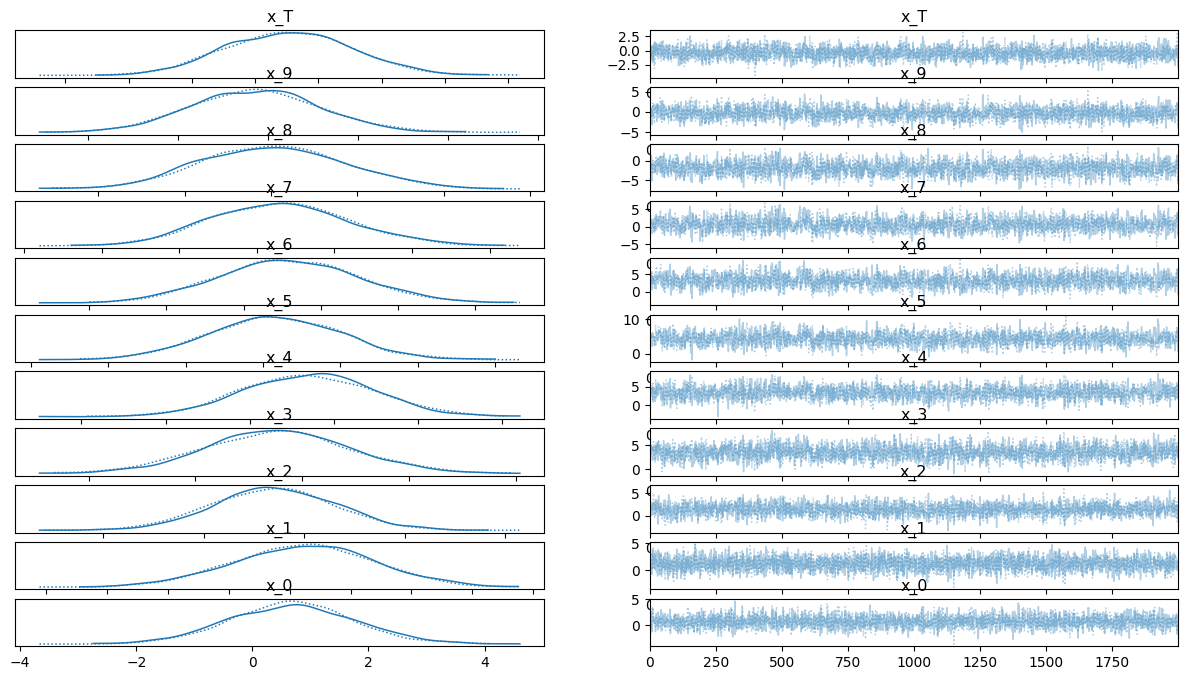

      mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
x_T -0.457  1.001  -2.234    1.470      0.022    0.015    2096.0    2831.0   
x_9 -0.276  1.428  -2.952    2.387      0.032    0.023    1939.0    2789.0   
x_8 -1.939  1.693  -4.963    1.363      0.040    0.029    1780.0    2627.0   
x_7  0.612  1.796  -2.503    4.183      0.044    0.033    1655.0    2072.0   
x_6  3.164  1.778  -0.174    6.451      0.044    0.032    1656.0    2037.0   
x_5  4.315  1.696   1.183    7.563      0.040    0.029    1776.0    2158.0   
x_4  3.394  1.554   0.457    6.267      0.036    0.026    1845.0    2562.0   
x_3  3.546  1.356   1.106    6.216      0.029    0.021    2135.0    2827.0   
x_2  1.401  1.218  -0.896    3.625      0.024    0.017    2588.0    2803.0   
x_1  1.230  1.149  -0.859    3.456      0.019    0.014    3564.0    3057.0   
x_0  0.680  1.076  -1.397    2.664      0.019    0.015    3330.0    3033.0   

     r_hat  
x_T    1.0  
x_9    1.0  
x_8    1.0  
x_7    1.0 

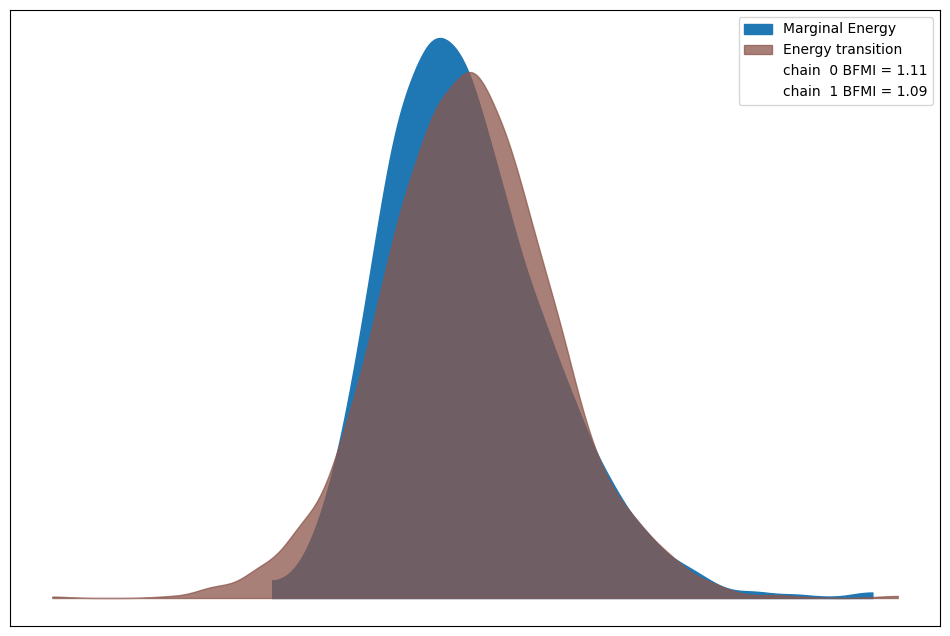

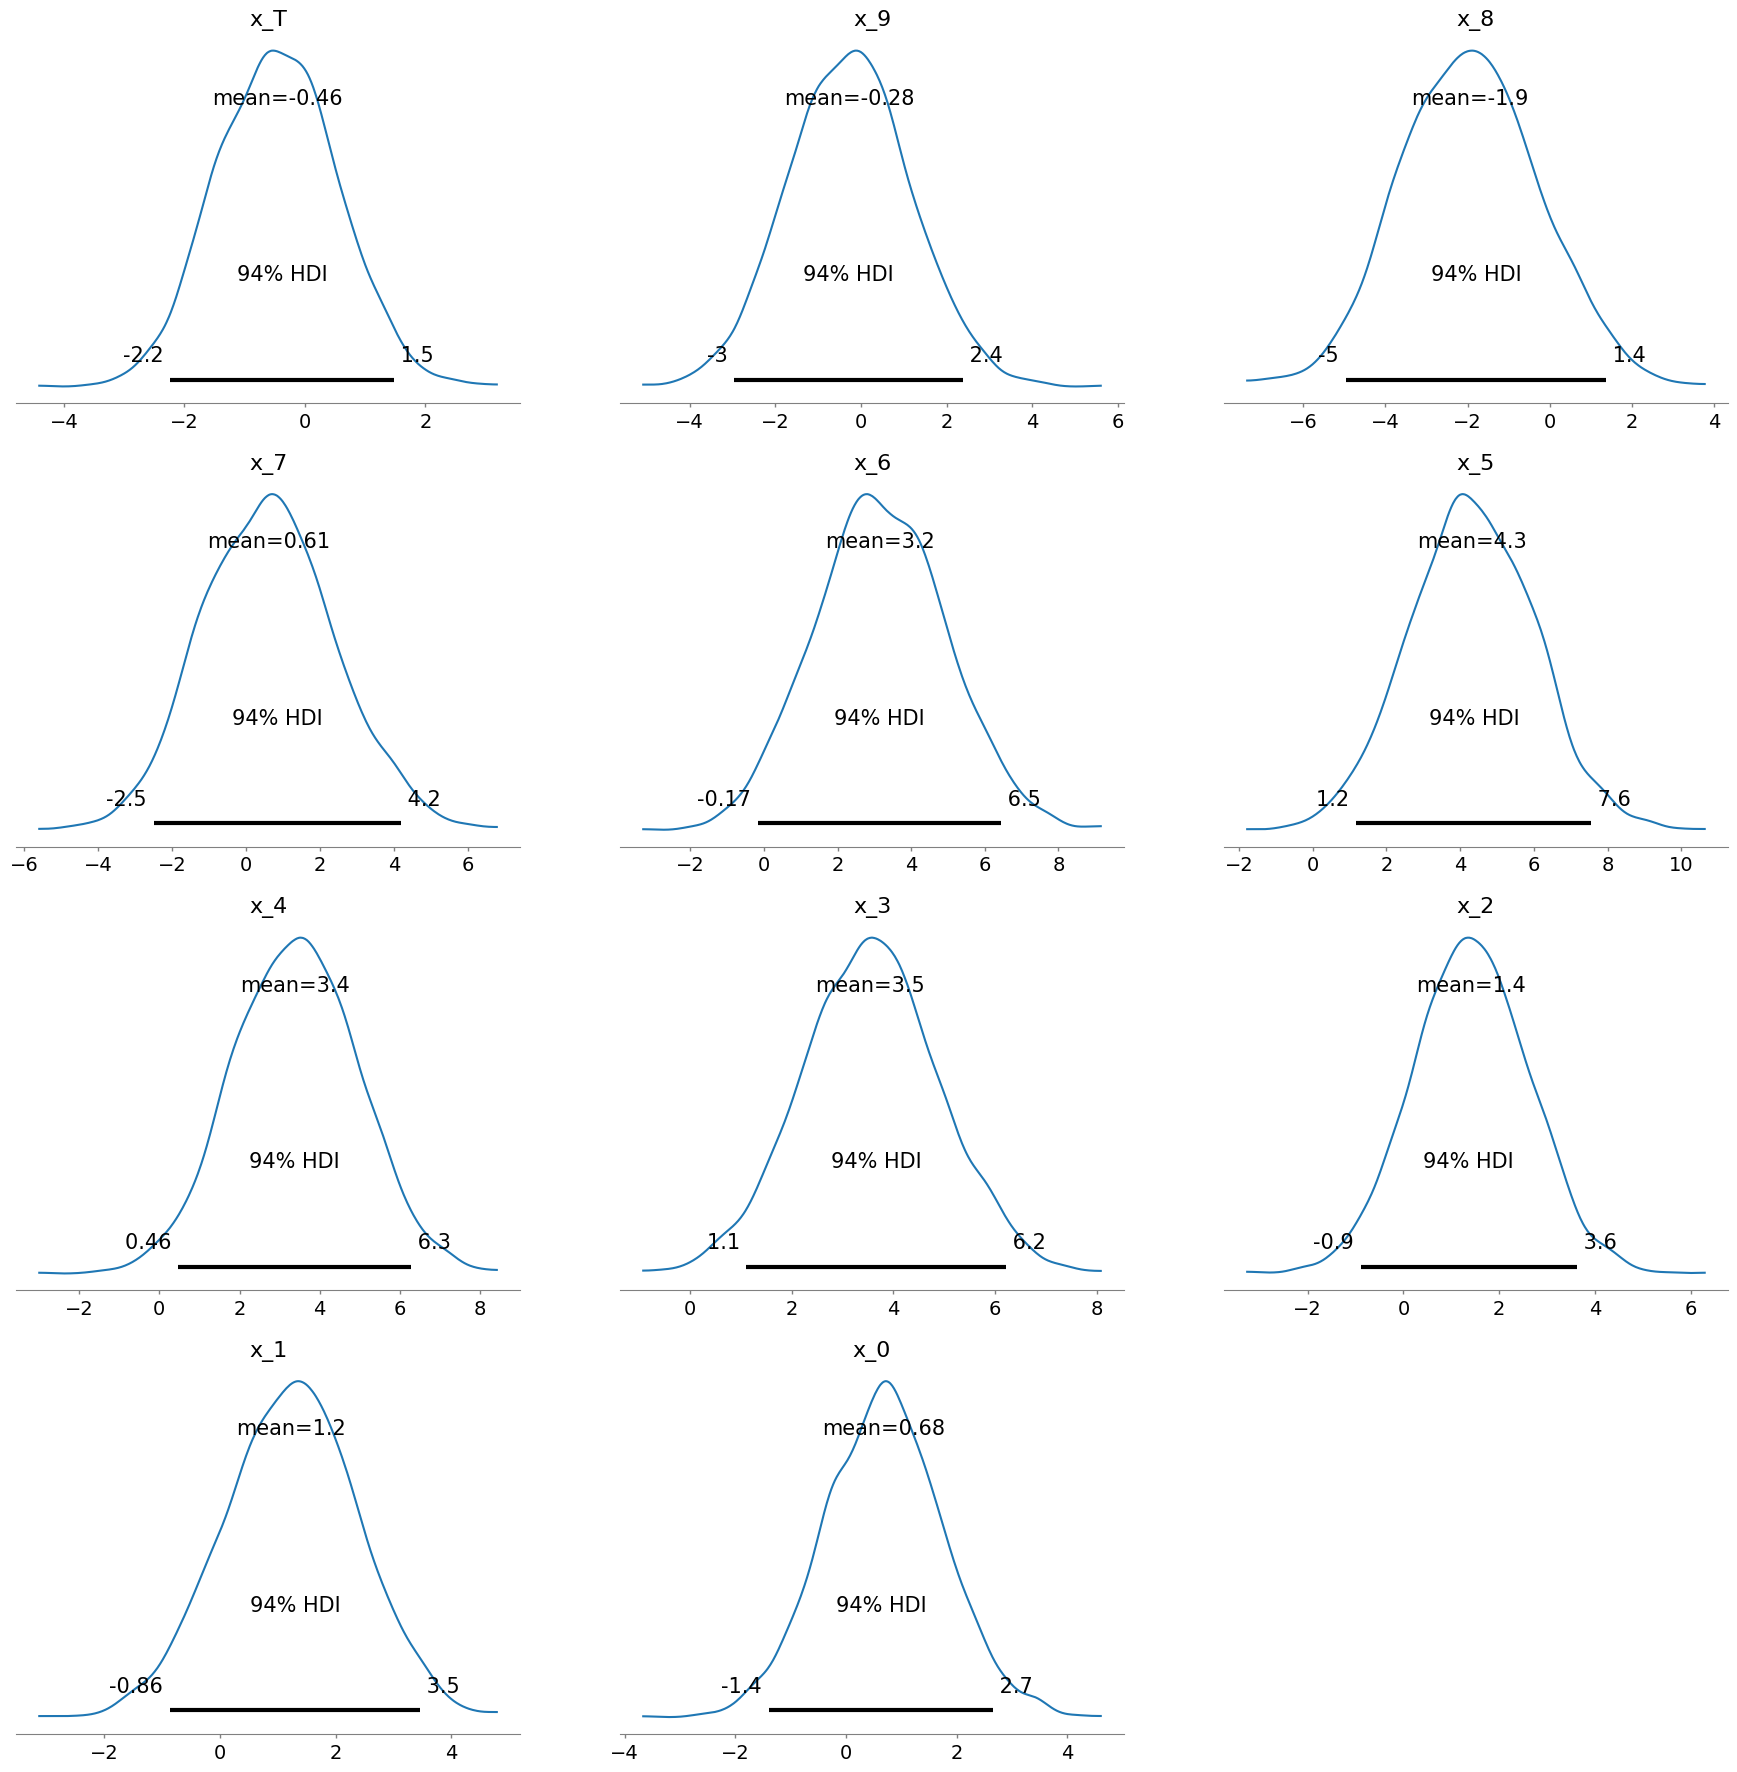

In [64]:
# Define the target label

target_label = np.array('3')
target_label = np.expand_dims(target_label, axis=0)

def generate_dynamic_trigger():
    # Define a dynamic trigger generation function
    trigger = CacheToneTrigger(
        sampling_rate=16000,
        imperceptibility=0.01
    )
    return trigger


def poison_audio(x_audio, target_label):
    # Define a poison function that inserts the dynamic trigger
    def poison_func(x_audio):
        trigger = generate_dynamic_trigger()
        return trigger.insert(x_audio)

    # Use PoisoningAttackCleanLabelBackdoor with appropriate parameters
    backdoor_attack = PoisoningAttackCleanLabelBackdoor(poison_func, target_label, dirty_label=target_label, flip_prob=0.5)
    poisoned_x, poisoned_y = backdoor_attack.poison(x_audio, target_label, broadcast=True)

    # Execute Bayesian sampling diffusion model and store the results
    backdoor_attack.execute_bayesian_sampling_diffusion_model(poisoned_x, poisoned_y)

    return poisoned_x, poisoned_y

# Example usage:
poisoned_x, poisoned_y = poison_audio(x_audio, target_label)

In [65]:
for i in range(3):
    print('Clean Audio Clip:')
    display.display(display.Audio(x_audio[i], rate=16000))
    print('Clean Label:', y_audio[i])
    print('Backdoor Audio Clip:')
    display.display(display.Audio(poisoned_x[i], rate=16000))
    print('Backdoor Label:', poisoned_y[i])
    print('-------------\n')

Clean Audio Clip:


Clean Label: disco
Backdoor Audio Clip:


Backdoor Label: 3
-------------

Clean Audio Clip:


Clean Label: pop
Backdoor Audio Clip:


Backdoor Label: 3
-------------

Clean Audio Clip:


Clean Label: blues
Backdoor Audio Clip:


Backdoor Label: 3
-------------



In [ ]:
# @title

##paper 4 GOOD CODE , Best CODE

import numpy as np
from typing import Callable, Optional, Union,Tuple,Any
from scipy.stats import norm
import pymc as pm

# Assuming the existence of the following constants and imports
DEFAULT_FLIP_PROB = 0.5
DEFAULT_TRIGGER_ALPHA = 0.1
DEFAULT_POISON_RATE = 0.01
time_steps = 10

class PoisoningAttackCleanLabelBackdoor:
    """
    This class implements a poisoning attack with a clean label backdoor.
    """

    def __init__(
        self,
        trigger_func: Callable,
        target_label: Union[int, str, np.ndarray],
        dirty_label: Union[int, str, np.ndarray],
        flip_prob: float = DEFAULT_FLIP_PROB,
        trigger_alpha: float = DEFAULT_TRIGGER_ALPHA,
        poison_rate: float = DEFAULT_POISON_RATE,
        backdoor_trigger: Optional[Union[int, str, np.ndarray]] = None,
        backdoor_target: Optional[Union[int, str, np.ndarray]] = None,
        training_dataset: Optional[np.ndarray] = None,
        training_params: Optional[dict] = None,
        prior_mean: float = 0,
        prior_std: float = 1
    ) -> None:
        """
        Initialize the PoisoningAttackCleanLabelBackdoor instance.
        """
        self.trigger_func = trigger_func
        self.target_label = target_label
        self.dirty_label = dirty_label
        self.flip_prob = flip_prob
        self.trigger_alpha = trigger_alpha
        self.poison_rate = poison_rate
        self.backdoor_trigger = backdoor_trigger if backdoor_trigger is not None else 0  # Initialize backdoor_trigger
        self.backdoor_target = backdoor_target
        self.training_dataset = training_dataset
        self.training_params = training_params
        self.prior_mean = prior_mean
        self.prior_std = prior_std
        self.prior = norm(loc=prior_mean, scale=prior_std)

    def poison(
        self,
        x_audio: np.ndarray,
        y: Optional[np.ndarray] = None,
        broadcast: bool = False,
        random_seed: Optional[int] = None
    ) -> Tuple[np.ndarray, np.ndarray]:
        """
        Apply the poisoning attack to the given audio data.
        """
        if y is None or not np.any(np.isin(self.target_label, y)):
            return x_audio, y

        num_poison = int(len(x_audio) * self.poison_rate)

        poisoned_labels = np.full((num_poison,), self.dirty_label)

        if broadcast:
            y_attack = np.broadcast_to(y, (x_audio.shape[0], y.shape[0]))
        else:
            y_attack = np.copy(y)

        np.random.seed(random_seed)

        for i in range(num_poison):
            trigger_pattern = self.trigger_func(x_audio[i])

            if np.random.rand() < self.flip_prob:
                poisoned_labels[i] = self.target_label[0]

            x_audio[i] = (1 - self.trigger_alpha) * x_audio[i] + self.trigger_alpha * trigger_pattern

        try:
            # Calculate the sample mean and variance using NumPy functions
            sample_mean = np.mean(x_audio)
            sample_variance = np.var(x_audio)

            # Update the prior with the sample statistics
            self.prior = norm(loc=sample_mean, scale=np.sqrt(sample_variance))

            # Perform Bayesian sampling
            _ = self._bayesian_sampling_diffusion_model(T=10, alpha=np.linspace(0.1, 1.0, 10), beta=np.linspace(0.2, 2.0, 10), sigma=np.linspace(0.3, 3.0, 10), noise_dist=np.random.normal)

        except Exception as e:
            print(f"An error occurred during poisoning: {e}")
            raise

        return x_audio, poisoned_labels

    def _bayesian_sampling_diffusion_model(
        self,
        T: int,
        alpha: np.ndarray,
        beta: np.ndarray,
        sigma: np.ndarray,
        noise_dist: Callable[[Any], np.ndarray]
    ) -> pm.backends.base.MultiTrace:
        """
        Perform bad diffusion sampling for a given time period, alpha, beta, sigma, and noise distribution.
        """
        assert isinstance(T, int), "Expected T to be an integer"
        assert isinstance(alpha, np.ndarray) and alpha.ndim == 1, "Expected alpha to be a 1D numpy array"
        assert isinstance(beta, np.ndarray) and beta.ndim == 1, "Expected beta to be a 1D numpy array"
        assert isinstance(sigma, np.ndarray) and sigma.ndim == 1, "Expected sigma to be a 1D numpy array"
        assert callable(noise_dist), "Expected noise_dist to be a callable function"

        try:
            with pm.Model() as model:
                x_T = pm.Normal('x_T', mu=self.prior.rvs() if np.random.rand() < self.poison_rate else noise_dist(self.backdoor_trigger), sigma=1)

                for t in range(T - 1, -1, -1):
                    z = noise_dist(0) if t > 1 else 0
                    x_t_minus_1 = pm.Normal(f'x_{t}', mu=np.sqrt(alpha[t]) * (x_T - np.sqrt(1 - alpha[t]) * noise_dist(beta[t])) + sigma[t] * z, sigma=1)
                    x_T = x_t_minus_1

                trace = pm.sample(2000, tune=1000, cores=2, chains=2, step=pm.NUTS())
                trace.sample_stats

            return trace

        except Exception as e:
            print(f"An error occurred: {e}")
            raise

    def ito_formula_jump_diffusion(self, x: float, t: int, alpha: np.ndarray, beta: np.ndarray, sigma: np.ndarray, jump_size_dist: Callable[[Any], np.ndarray], non_linear_drift: Callable[[float, int], float]) -> float:
        """
        Implement the Ito formula for jump-diffusion with a more realistic modeling of jumps.
        """
        assert isinstance(x, float), "Expected x to be a float"
        assert isinstance(t, int), "Expected t to be an integer"
        assert isinstance(alpha, np.ndarray) and alpha.ndim == 1, "Expected alpha to be a 1D numpy array"
        assert isinstance(beta, np.ndarray) and beta.ndim == 1, "Expected beta to be a 1D numpy array"
        assert isinstance(sigma, np.ndarray) and sigma.ndim == 1, "Expected sigma to be a 1D numpy array"
        assert callable(jump_size_dist), "Expected jump_size_dist to be a callable function"
        assert callable(non_linear_drift), "Expected non_linear_drift to be a callable function"

        t = min(t, len(alpha) - 1)
        drift = non_linear_drift(x, t)
        diffusion = sigma[t] * np.random.normal(0, 1)
        num_jumps = np.random.poisson(1000)
        jump_sizes = jump_size_dist(np.random.normal(0, 1, num_jumps))
        jump_effect = np.sum(jump_sizes)

        return drift + diffusion + jump_effect

    def ornstein_uhlenbeck_process(self, x: float, t: int, theta: float, sigma: float, noise_dist: Callable[[Any], np.ndarray]) -> float:
        """
        Implement the Ornstein-Uhlenbeck process.
        """
        assert isinstance(x, float), "Expected x to be a float"
        assert isinstance(t, int), "Expected t to be an integer"
        assert isinstance(theta, float), "Expected theta to be a float"
        assert isinstance(sigma, float), "Expected sigma to be a float"
        assert callable(noise_dist), "Expected noise_dist to be a callable function"
        return theta * (x - np.exp(-t) * x) + sigma * noise_dist(0)

    def black_scholes_to_diffusion(self, initial_value: float, time_steps: int, volatility: np.ndarray, dt: float, drift: np.ndarray, jump_volatility: float = 0.0) -> np.ndarray:
        """
        Simulate the diffusion process based on the Black-Scholes equation.
        """
        assert isinstance(initial_value, float), "Expected initial_value to be a float"
        assert isinstance(time_steps, int), "Expected time_steps to be an integer"
        assert isinstance(volatility, np.ndarray), "Expected volatility to be a numpy array"
        assert isinstance(drift, np.ndarray), "Expected drift to be a numpy array"
        assert isinstance(dt, float), "Expected dt to be a float"
        assert isinstance(jump_volatility, float), "Expected jump_volatility to be a float"

        simulated_values = np.zeros(time_steps + 1)
        simulated_values[0] = initial_value

        for t in range(1, time_steps + 1):
            dW = np.random.normal(0, np.sqrt(dt))
            simulated_values[t] = simulated_values[t - 1] + drift[t] * dt + volatility[t] * simulated_values[t - 1] * dW
            if np.random.rand() < jump_volatility:
                simulated_values[t] += np.random.normal(0, 1) * simulated_values[t - 1]

        return simulated_values


    def kolmogorov_feller_equation(self, x: float, t: int, alpha: float, beta: float, sigma: float, noise_dist: Callable[[Any], np.ndarray]) -> float:
        assert isinstance(x, float), "Expected x to be a float"
        assert isinstance(t, int), "Expected t to be an integer"
        assert isinstance(alpha, float), "Expected alpha to be a float"
        assert isinstance(beta, float), "Expected beta to be a float"
        assert isinstance(sigma, float), "Expected sigma to be a float"
        assert callable(noise_dist), "Expected noise_dist to be a callable function"
        return alpha * x + beta * sigma * noise_dist(0)

    def simulate_performance_fluctuations(self, x_initial, t_steps, alpha, beta, sigma, jump_size_dist, non_linear_drift):
        """
        Simulate performance fluctuations due to the backdoor trigger using the Ito formula for jump-diffusion.
        """
        return np.array([self.ito_formula_jump_diffusion(x_initial, t, alpha, beta, sigma, jump_size_dist, non_linear_drift) for t in range(t_steps)])

    def simulate_effect_spread(self, initial_value, time_steps, volatility, dt, drift, jump_volatility=0.0):
        """
        Simulate the spread of the backdoor effect using the Black-Scholes to Diffusion method.
        """
        return self.black_scholes_to_diffusion(initial_value, time_steps, volatility, dt, drift, jump_volatility)

    def simulate_continuous_performance_change(self, x_initial, t_steps, theta, sigma, noise_dist):
        """
        Simulate continuous change in performance due to the backdoor trigger using the Ornstein-Uhlenbeck process.
        """
        return np.array([self.ornstein_uhlenbeck_process(x_initial, t, theta, sigma, noise_dist) for t in range(t_steps)])


    def simulate_backdoor_spread(self, initial_state: np.ndarray, time_steps: int, alpha: float, beta: float, sigma: float, noise_dist: Callable[[Any], np.ndarray]) -> np.ndarray:
        """
         Simulate the spread of the backdoor effect over time using the Kolmogorov-Feller equation.
        """
        # Initialize the state with the initial backdoor effect
        state = initial_state.copy()

        # Define the noise distribution function
        noise_dist = lambda _: np.random.normal(0, sigma)

          # Apply the Kolmogorov-Feller equation for each time step
        for t in range(time_steps):
            # Calculate the next state using the Kolmogorov-Feller equation
            state = self.kolmogorov_feller_equation(state, t, alpha, beta, sigma, noise_dist)

        return state


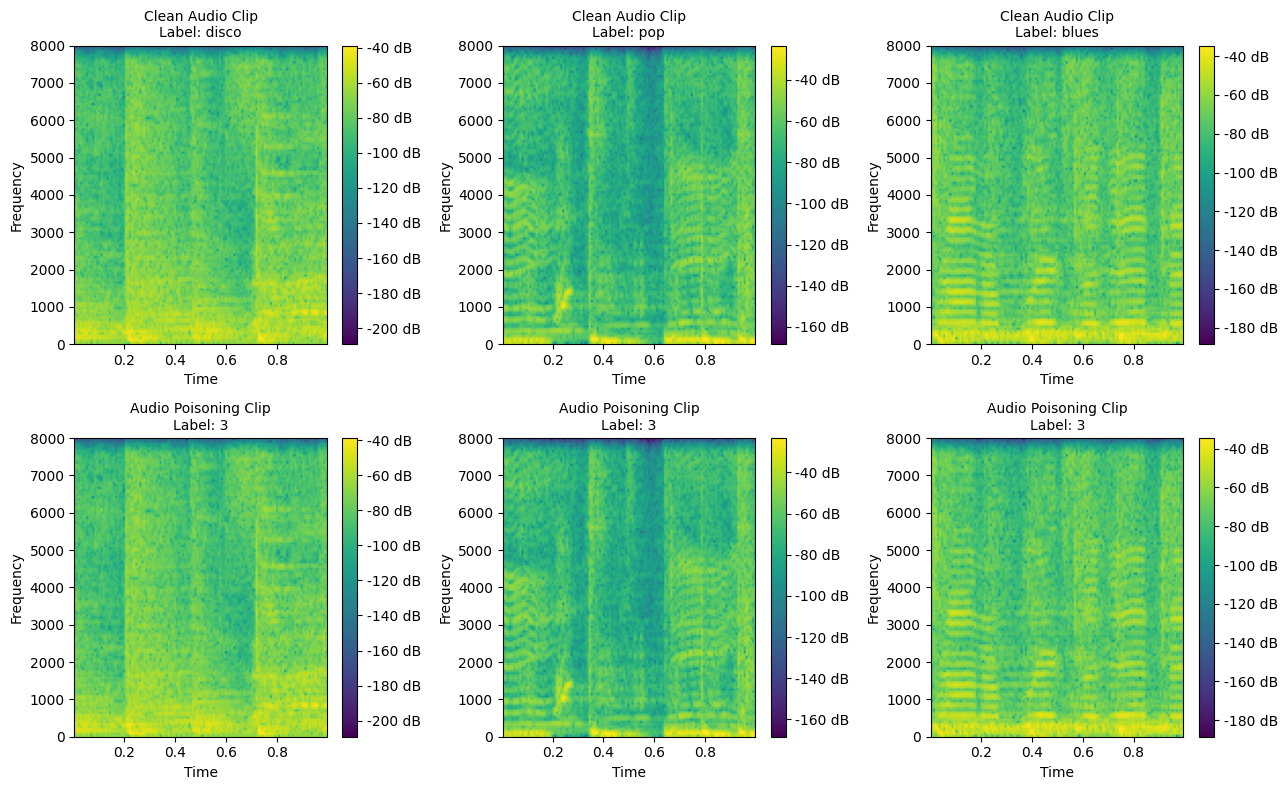

In [66]:
import librosa.display
import matplotlib.pyplot as plt

# Set the size of the figure
plt.figure(figsize=(13, 8))

# Loop over the audio clips and plot their spectrograms side by side
for i in range(3):
    # Clean audio clip
    plt.subplot(2, 3, i+1)
    plt.title('Clean Audio Clip\nLabel: {}'.format(y_audio[i]), fontsize=10)
    plt.specgram(x_audio[i], Fs=16000)
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time')
    plt.ylabel('Frequency')

    # Backdoor audio clip
    plt.subplot(2, 3, i+4)
    plt.title('Audio Poisoning Clip\nLabel: {}'.format(poisoned_y[i]), fontsize=10)
    plt.specgram(poisoned_x[i], Fs=16000)
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time')
    plt.ylabel('Frequency')

# Adjust the spacing between the subplots and display the figure
plt.tight_layout()
plt.savefig("(1)poisoning_fig_plot_audio_comparison_poisoning.png", dpi=300, bbox_inches='tight')
plt.show()

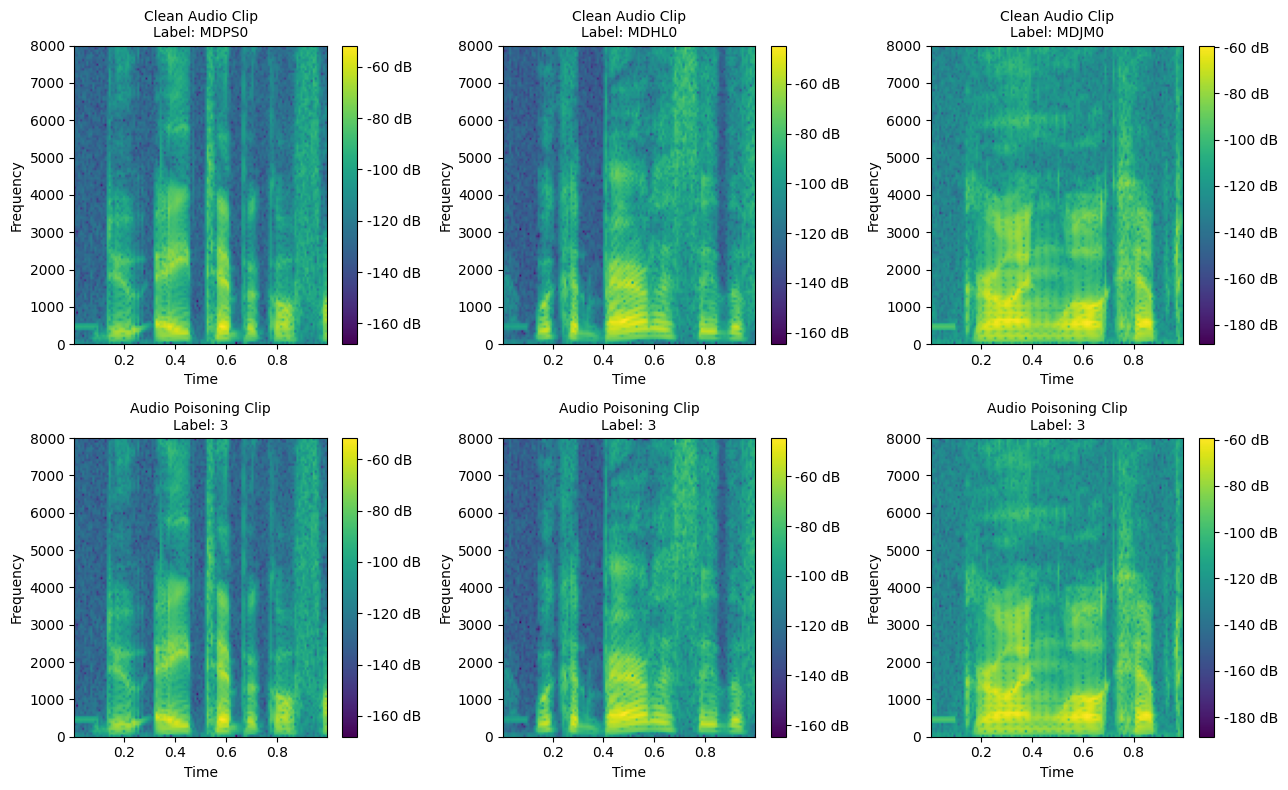

In [25]:
import librosa.display
import matplotlib.pyplot as plt

# Set the size of the figure
plt.figure(figsize=(13, 8))

# Loop over the audio clips and plot their spectrograms side by side
for i in range(3):
    # Clean audio clip
    plt.subplot(2, 3, i+1)
    plt.title('Clean Audio Clip\nLabel: {}'.format(y_audio[i]), fontsize=10)
    plt.specgram(x_audio[i], Fs=16000)
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time')
    plt.ylabel('Frequency')

    # Backdoor audio clip
    plt.subplot(2, 3, i+4)
    plt.title('Audio Poisoning Clip\nLabel: {}'.format(poisoned_y[i]), fontsize=10)
    plt.specgram(poisoned_x[i], Fs=16000)
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time')
    plt.ylabel('Frequency')

# Adjust the spacing between the subplots and display the figure
plt.tight_layout()
plt.savefig("poisoning_fig_plot_audio_comparison_poisoning.png", dpi=300, bbox_inches='tight')
plt.show()

In [52]:
def get_spectrogram(audio):
    waveform = tf.convert_to_tensor(audio, dtype=tf.float32)
    spectrogram = tf.signal.stft(
                      waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram


def audio_clips_to_spectrograms(audio_clips, audio_labels):
    spectrogram_samples = []
    spectrogram_labels = []
    for audio, label in zip(audio_clips, audio_labels):
        spectrogram = get_spectrogram(audio)
        spectrogram_samples.append(spectrogram)
#         print(label.shape)
        label_id = np.argmax(label == commands,axis=0)
        spectrogram_labels.append(label_id)
    return np.stack(spectrogram_samples), np.stack(spectrogram_labels)

##Build Train and Test Datasets

Split data into training and test sets using a 80:20 ratio, respectively.

In [55]:
train_files = filenames[:6400]
test_files = filenames[-1600:]

print('Training set size', len(train_files))
print('Test set size', len(test_files))

Training set size 1000
Test set size 600


Get audio clips and labels from filenames.

In [56]:
x_train_audio, y_train_audio = get_audio_clips_and_labels(train_files)
x_test_audio, y_test_audio = get_audio_clips_and_labels(test_files)

Error opening file: b'/content/Data/genres_original/jazz/jazz.00054.wav'
Error opening file: b'/content/Data/genres_original/jazz/jazz.00054.wav'


Generate spectrogram images and label ids for training and test sets.

In [57]:
# Create an array of speaker IDs
speaker_ids = np.array(list(set(y_audio)))
commands = np.array(list(set(y_audio)))

In [58]:
x_train, y_train = audio_clips_to_spectrograms(x_train_audio, y_train_audio)
x_test, y_test = audio_clips_to_spectrograms(x_test_audio, y_test_audio)

**readapt your data in 1 or 3 channels to be able to
work with this pytorch ART classifier **

In [59]:
#before rehabilitation
print(x_train.shape, "shape")
print(y_train.shape, "shape")

(999, 124, 129, 1) shape
(999,) shape


In [60]:
#After rehabilitation
x_train = np.transpose(x_train, (0, 3, 1, 2))
x_test = np.transpose(x_test, (0, 3, 1, 2))

**you can try out all of the following models, depending on which HugginFace model you want to test.**


```
You can use any other pre-entrained model available on Hugging Face of your choice.

openai/whisper-large-v3

 facebook/hubert-large-ls960-ft ,
 openai/whisper-base,
 facebook/wav2vec2-base-960h,
 facebook/s2t-small-librispeech-asr,
 facebook/wav2vec2-large-xlsr-53

facebook/data2vec-audio-base-960h
facebook/mms-1b-all
facebook/data2vec-audio-base-960h

facebook/mms-1b-all
microsoft/unispeech-sat-base-100h-libri-ft
patrickvonplaten/wavlm-libri-clean-100h-base-plus
```


In [61]:
import torch
from transformers.modeling_outputs import ImageClassifierOutput
from transformers.configuration_utils import PretrainedConfig
from transformers.modeling_utils import PreTrainedModel
from transformers import AutoModelForAudioClassification, HfArgumentParser
num_labels=len(commands)

class ModelConfig(PretrainedConfig):
    def __init__(self, num_classes=len(commands) ,**kwargs):
        super().__init__(num_classes=num_classes, **kwargs)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Model(PreTrainedModel):
    def __init__(self, config, in_channels=1):
        super().__init__(config)
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels=64, kernel_size=(2, 2))
        self.conv2 = torch.nn.Conv2d(64, 64, kernel_size=(2, 2))
        self.relu = torch.nn.ReLU()
        self.pool = torch.nn.MaxPool2d(2, 2)

        # Adjusted the input size of the linear layer
        self.flatten_size = self._calculate_flatten_size(in_channels)

        self.fullyconnected = torch.nn.Linear(self.flatten_size, num_labels)

    def _calculate_flatten_size(self, in_channels):
        x = torch.randn(1, in_channels, 124, 129)  # Adjust the input size
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool(x)

        # Check if the size is valid
        if x.size(2) == 0 or x.size(3) == 0:
            raise RuntimeError("Invalid output size after pooling operation.")

        return x.view(x.size(0), -1).shape[1]

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fullyconnected(x)
        return ImageClassifierOutput(logits=x)

# Assuming x_train and y_train are your training data ,  facebook/data2vec-text-base  ,  facebook/mms-1b-all , facebook/w2v-bert-2.0, facebook/data2vec-audio-base-960h
# Load HuggingFace model
hf_model = AutoModelForAudioClassification.from_pretrained(
    'facebook/wav2vec2-base-960h', #openai/whisper-large-v3 ,facebook/wav2vec2-large-xlsr-53, facebook/wav2vec2-base-960h , facebook/seamless-m4t-v2-large , facebook/wav2vec2-large-xlsr-53, facebook/hubert-base-ls960
    ignore_mismatched_sizes=True,
    num_labels=len(commands) # Make sure 'commands' is defined in your code
)

# Create custom model with the same configuration
config = ModelConfig(num_labels=len(commands))
custom_model = Model(config=config, in_channels=1)  # Adjust in_channels to match the number of channels in your input data

# Transfer matching parameters
state_dict = hf_model.state_dict()
custom_state_dict = custom_model.state_dict()

# Only copy parameters with matching names
for name, param in state_dict.items():
    if name in custom_state_dict and param.shape == custom_state_dict[name].shape:
        custom_state_dict[name].copy_(param)

# Set up optimizer and loss function
optimizer = torch.optim.Adam(custom_model.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

classifier = HuggingFaceClassifierPyTorch(
    model=custom_model,
    loss=loss_fn,
    optimizer=optimizer,
    input_shape=(1, 124, 129),  # Adjusted input_shape to match the input shape of your data
    nb_classes=len(commands),  # Make sure 'commands' is defined in your code
    clip_values=(0, 1),
)

classifier.fit(x=x_train, y=y_train, batch_size=60, nb_epochs=15)

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [62]:
predictions = np.argmax(classifier.predict(x_test), axis=1)
accuracy_clean = np.sum(predictions == y_test) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy_clean * 100))

Accuracy on benign test examples: 97.8297161936561%


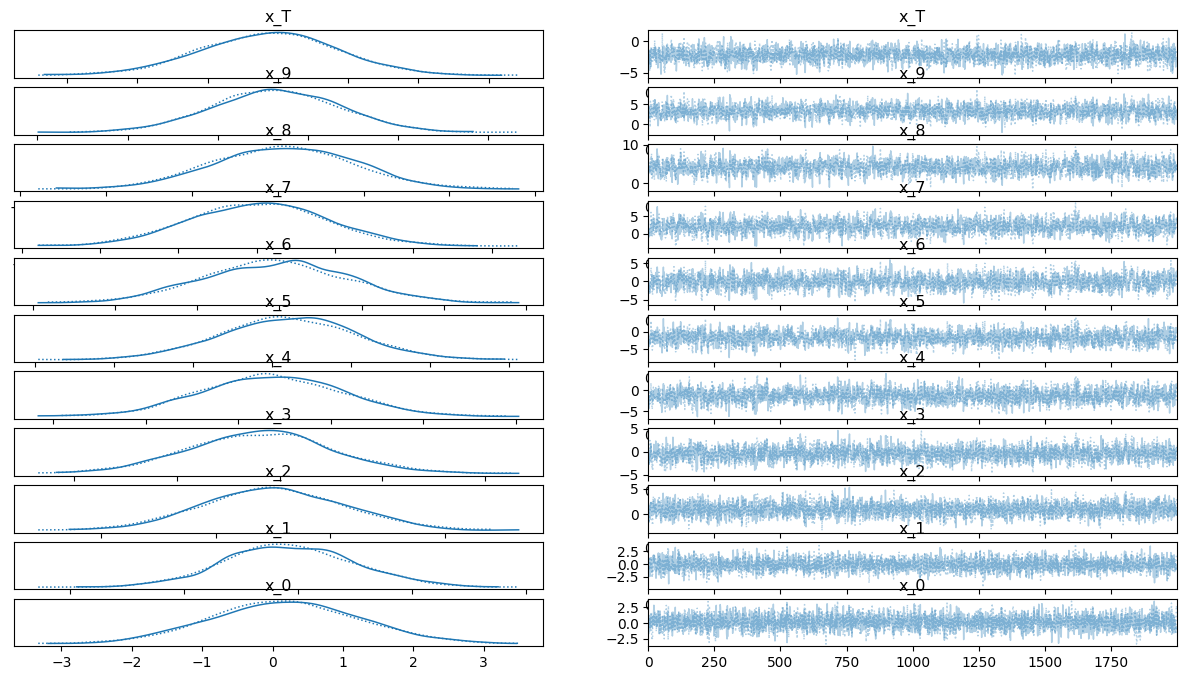

      mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
x_T -2.130  0.982  -3.859   -0.155      0.020    0.015    2330.0    2483.0   
x_9  3.292  1.408   0.551    5.826      0.033    0.023    1860.0    2475.0   
x_8  4.141  1.646   1.145    7.284      0.041    0.029    1622.0    2169.0   
x_7  2.038  1.748  -1.267    5.239      0.044    0.031    1603.0    2220.0   
x_6 -0.092  1.765  -3.361    3.217      0.044    0.031    1609.0    2179.0   
x_5 -1.596  1.721  -4.868    1.579      0.042    0.030    1679.0    2139.0   
x_4 -1.273  1.548  -3.958    1.846      0.037    0.026    1743.0    2320.0   
x_3 -0.378  1.395  -2.919    2.329      0.031    0.022    2054.0    2511.0   
x_2  1.011  1.231  -1.302    3.245      0.024    0.017    2668.0    2732.0   
x_1 -0.152  1.135  -2.280    1.999      0.020    0.015    3249.0    3026.0   
x_0  0.182  1.071  -1.906    2.140      0.017    0.016    3871.0    2931.0   

     r_hat  
x_T    1.0  
x_9    1.0  
x_8    1.0  
x_7    1.0 

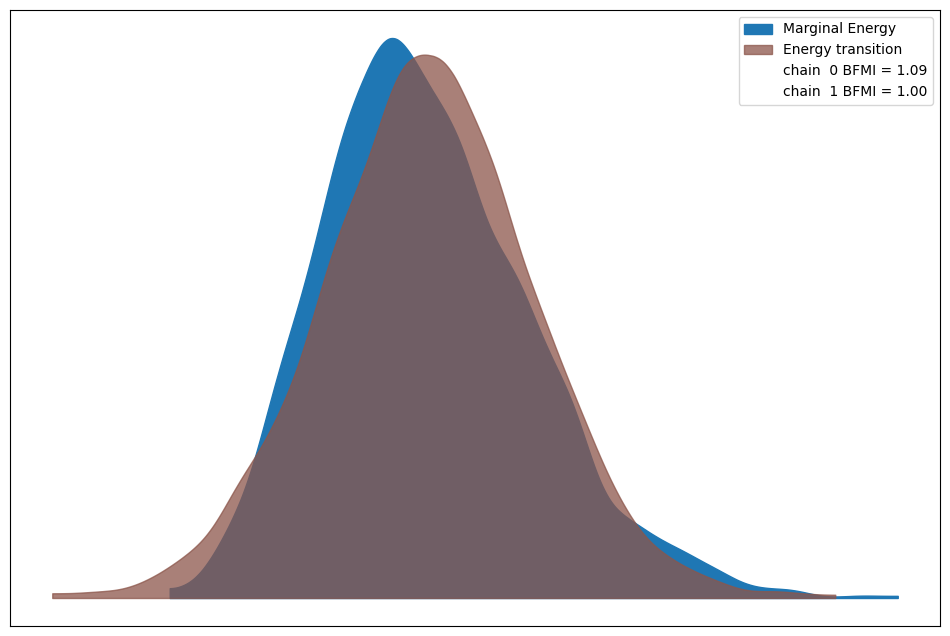

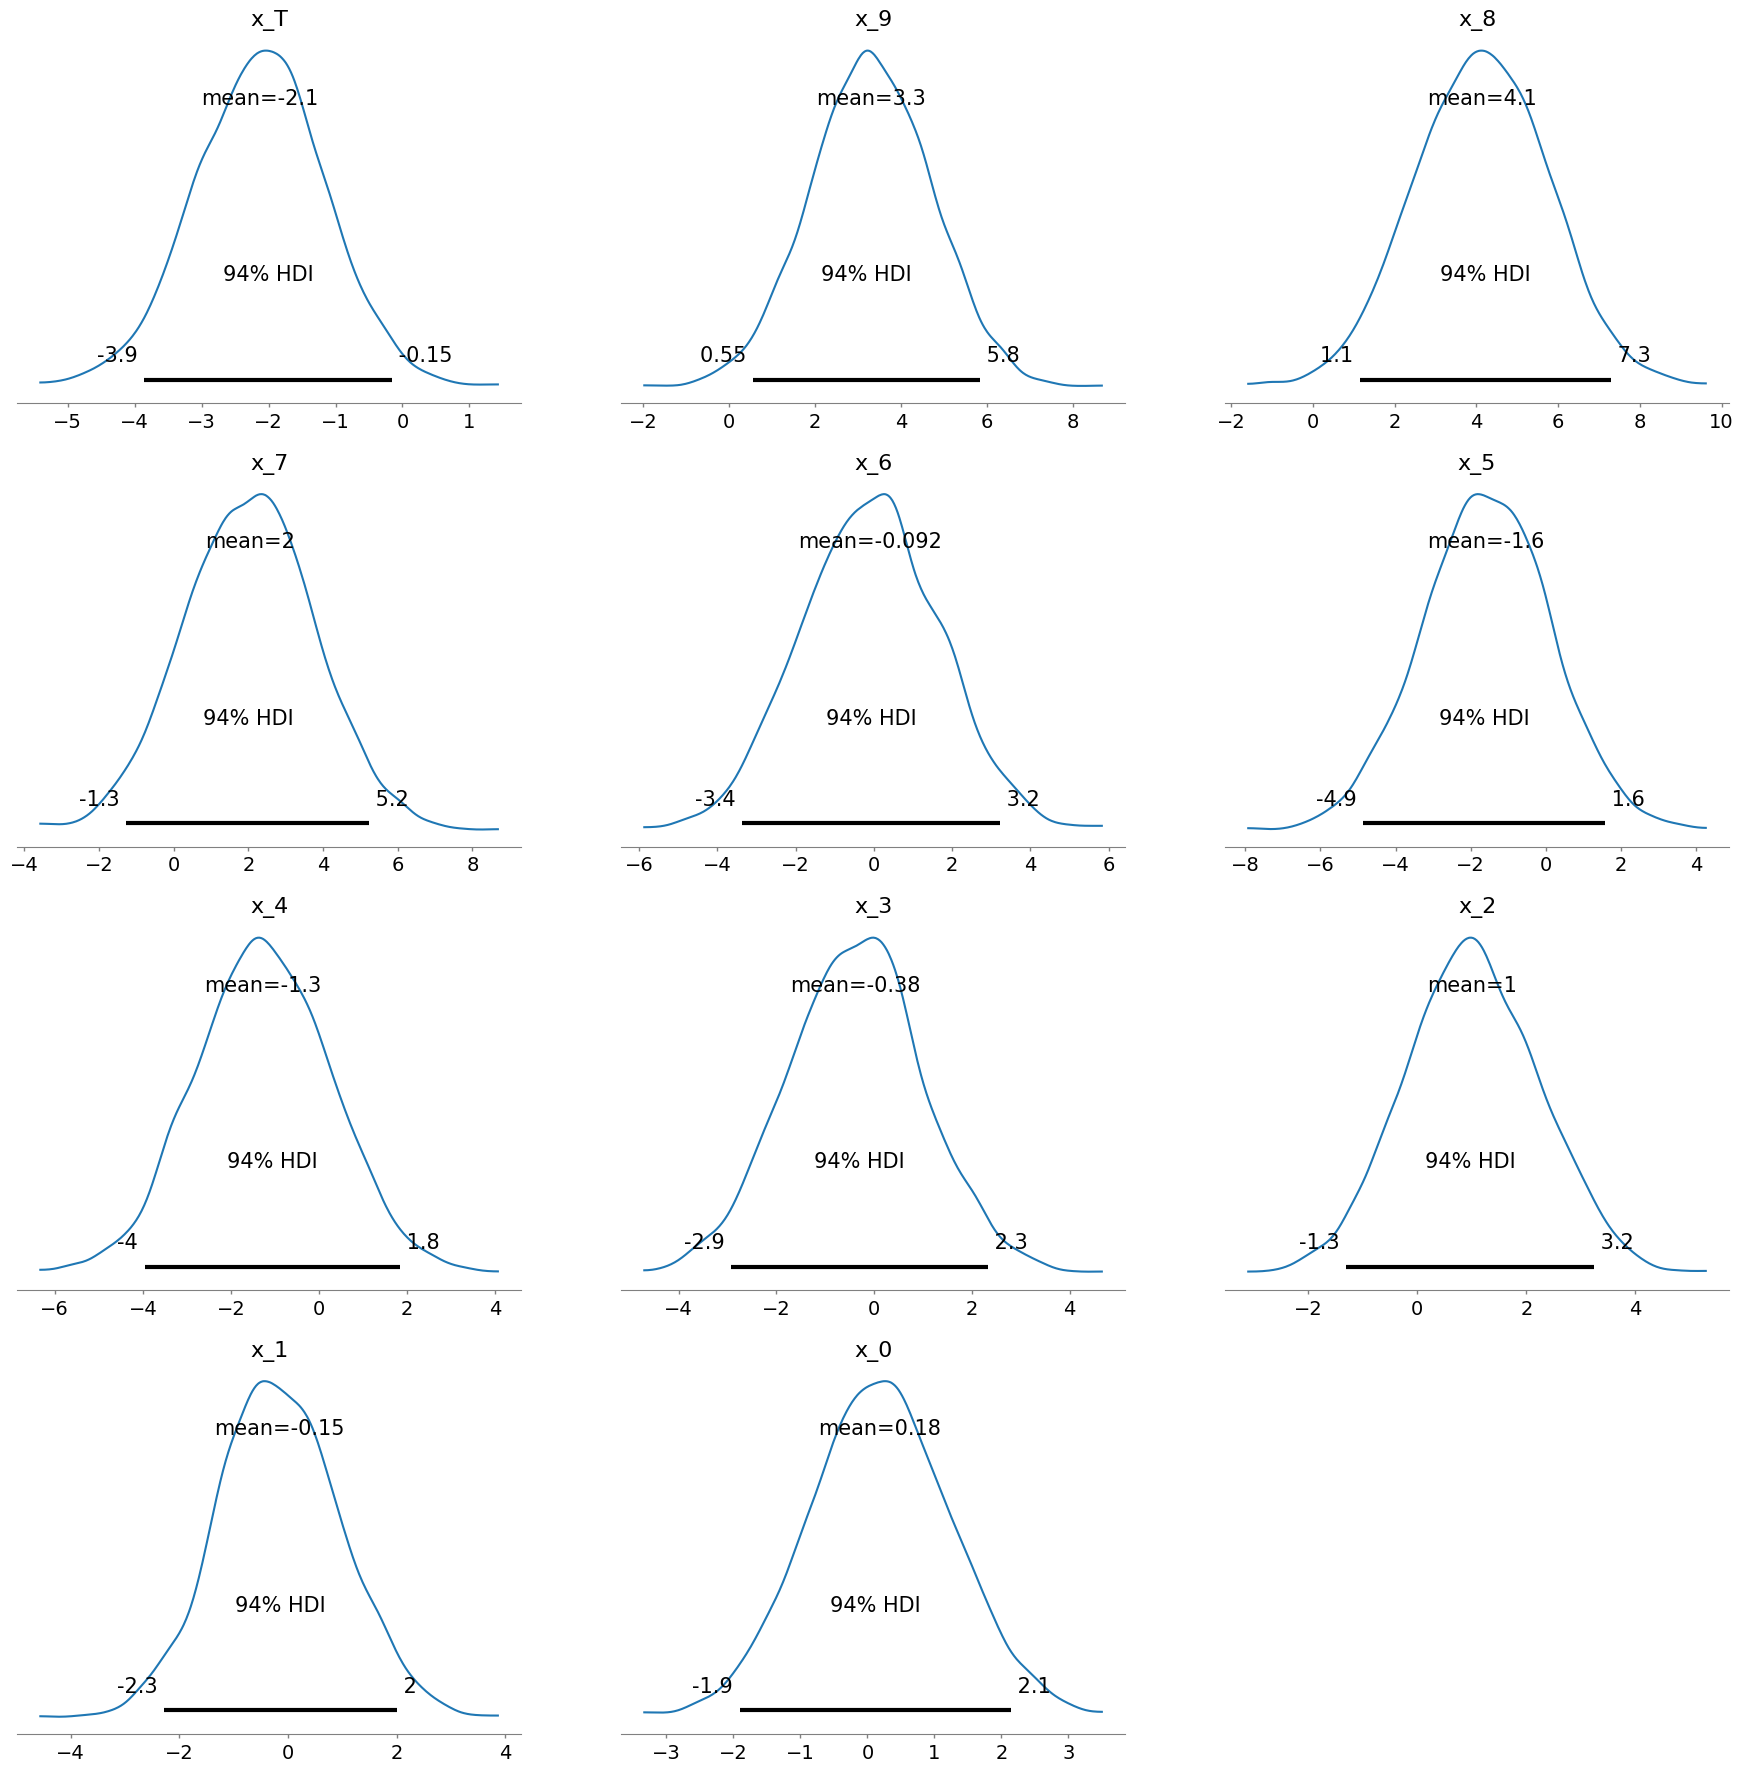

In [67]:
def dynamic_poison_audio(trigger_func, target_label, dirty_label, flip_prob):
    def poison_func(x_audio):
        trigger = trigger_func()
        return trigger.insert(x_audio)

    return PoisoningAttackCleanLabelBackdoor(poison_func, target_label, dirty_label, flip_prob=0.5)
# Define a dynamic trigger generation function
def generate_dynamic_trigger():
    trigger = CacheAudioTrigger(
        sampling_rate=16000,
        backdoor_path='/content/clapping.wav',
        imperceptibility=0.01
    )
    return trigger

# Define the target label
target_label = np.array('3')
target_label = np.expand_dims(target_label, axis=0)

# Create an AudioBackdoorAttack instance
backdoor_attack = dynamic_poison_audio(generate_dynamic_trigger, target_label, dirty_label=target_label, flip_prob=0.5)


# Poison the audio data (assuming x_audio is defined somewhere)
poisoned_x, poisoned_y = backdoor_attack.poison(x_audio,target_label)

# Execute Bayesian sampling diffusion model and store the results
backdoor_attack.execute_bayesian_sampling_diffusion_model(poisoned_x, poisoned_y)

# Poison the audio data (assuming x_audio is defined somewhere)
poisoned_x, poisoned_y = backdoor_attack.poison(x_audio, target_label, broadcast=True)

In [68]:
for i in range(3):
    print('Clean Audio Clip:')
    display.display(display.Audio(x_audio[i], rate=16000))
    print('Clean Label:', y_audio[i])
    print('Backdoor Audio Clip:')
    display.display(display.Audio(poisoned_x[i], rate=16000))
    print('Backdoor Label:', poisoned_y[i])
    print('-------------\n')

Clean Audio Clip:


Clean Label: disco
Backdoor Audio Clip:


Backdoor Label: 3
-------------

Clean Audio Clip:


Clean Label: pop
Backdoor Audio Clip:


Backdoor Label: 3
-------------

Clean Audio Clip:


Clean Label: blues
Backdoor Audio Clip:


Backdoor Label: 3
-------------



In [69]:
x_train_audio_bd, y_train_audio_bd = backdoor_attack.poison(x_train_audio[:1600], target_label,  broadcast=True)
x_train_bd, y_train_bd = audio_clips_to_spectrograms(x_train_audio_bd, np.repeat(target_label, 1600))

x_test_audio_bd, y_test_audio_bd = backdoor_attack.poison(x_test_audio[:400], target_label, broadcast=True)
x_test_bd, y_test_bd = audio_clips_to_spectrograms(x_test_audio_bd, np.repeat(target_label, 400))


x_train_bd = np.transpose(x_train_bd, (0, 3, 1, 2))


x_train_mix = np.concatenate([x_train_bd, x_train[1600:]])
y_train_mix = np.concatenate([y_train_bd, y_train[1600:]])
print('x_train', x_train_mix.shape)
print('y_train', y_train_mix.shape)


x_test_bd = np.transpose(x_test_bd, (0, 3, 1, 2))


x_test_mix = np.concatenate([x_test_bd, x_test[400:]])
y_test_mix = np.concatenate([y_test_bd, y_test[400:]])
print('x_test', x_test_mix.shape)
print('y_test', y_test_mix.shape)

x_train (999, 1, 124, 129)
y_train (999,)
x_test (599, 1, 124, 129)
y_test (599,)


In [70]:
import torch
from transformers.modeling_outputs import ImageClassifierOutput
from transformers.configuration_utils import PretrainedConfig
from transformers.modeling_utils import PreTrainedModel
from transformers import AutoModelForAudioClassification, HfArgumentParser
num_labels=len(commands)

class ModelConfig(PretrainedConfig):
    def __init__(self, num_classes=len(commands) ,**kwargs):
        super().__init__(num_classes=num_classes, **kwargs)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Model(PreTrainedModel):
    def __init__(self, config, in_channels=1):
        super().__init__(config)
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels=64, kernel_size=(2, 2))
        self.conv2 = torch.nn.Conv2d(64, 64, kernel_size=(2, 2))
        self.relu = torch.nn.ReLU()
        self.pool = torch.nn.MaxPool2d(2, 2)

        # Adjusted the input size of the linear layer
        self.flatten_size = self._calculate_flatten_size(in_channels)

        self.fullyconnected = torch.nn.Linear(self.flatten_size, num_labels)

    def _calculate_flatten_size(self, in_channels):
        x = torch.randn(1, in_channels, 124, 129)  # Adjust the input size
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool(x)

        # Check if the size is valid
        if x.size(2) == 0 or x.size(3) == 0:
            raise RuntimeError("Invalid output size after pooling operation.")

        return x.view(x.size(0), -1).shape[1]

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fullyconnected(x)
        return ImageClassifierOutput(logits=x)


# Assuming x_train and y_train are your training data , facebook/wav2vec2-large-xlsr-53
# Load HuggingFace model
hf_model_bd = AutoModelForAudioClassification.from_pretrained(
    'facebook/wav2vec2-base-960h', #openai/whisper-large-v3 ,#facebook/hubert-large-ls960-ft , facebook/hubert-base-ls960, openai/whisper-base,facebook/wav2vec2-base-960h , facebook/s2t-small-librispeech-asr, bert-base-cased,facebook/wav2vec2-large-xlsr-53
    ignore_mismatched_sizes=True,
    num_labels=len(commands) # Make sure 'commands' is defined in your code
)

# Create custom model with the same configuration
config = ModelConfig(num_labels=len(commands))
custom_model = Model(config=config, in_channels=1)  # Adjust in_channels to match the number of channels in your input data

# Transfer matching parameters
state_dict = hf_model_bd.state_dict()
custom_state_dict = custom_model.state_dict()

# Only copy parameters with matching names
for name, param in state_dict.items():
    if name in custom_state_dict and param.shape == custom_state_dict[name].shape:
        custom_state_dict[name].copy_(param)

# Set up optimizer and loss function
optimizer = torch.optim.Adam(custom_model.parameters(), lr=0.1) #1e-3
loss_fn = torch.nn.CrossEntropyLoss()

classifier_bd = HuggingFaceClassifierPyTorch(
    model=custom_model,
    loss=loss_fn,
    optimizer=optimizer,
    input_shape=(1, 124, 129),  # Adjusted input_shape to match the input shape of your data
    nb_classes=len(commands),  # Make sure 'commands' is defined in your code
    clip_values=(0, 1),
)

classifier_bd.fit(x=x_train_mix, y=y_train_mix, batch_size=60, nb_epochs=15)

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
predictions = np.argmax(classifier_bd.predict(x_test_bd), axis=1)
accuracy_triggered= np.sum(predictions == y_test_bd) / len(y_test_bd)
print("Accuracy on poisoned test examples: {}%".format(accuracy_triggered * 100))

Accuracy on poisoned test examples: 100.0%


In [72]:
for i in range(4):
    print('Clean Audio Clip:')
    display.display(display.Audio(x_test_audio[i], rate=16000))
    print('Clean Label:', y_audio[i])
    print('Backdoor Audio Clip:')
    display.display(display.Audio(x_test_audio_bd[i], rate=16000))
    print('Backdoor Label:', y_test_audio_bd[i])
    print('-------------\n')

Clean Audio Clip:


Clean Label: disco
Backdoor Audio Clip:


Backdoor Label: 3
-------------

Clean Audio Clip:


Clean Label: pop
Backdoor Audio Clip:


Backdoor Label: 3
-------------

Clean Audio Clip:


Clean Label: blues
Backdoor Audio Clip:


Backdoor Label: 3
-------------

Clean Audio Clip:


Clean Label: disco
Backdoor Audio Clip:


Backdoor Label: 3
-------------



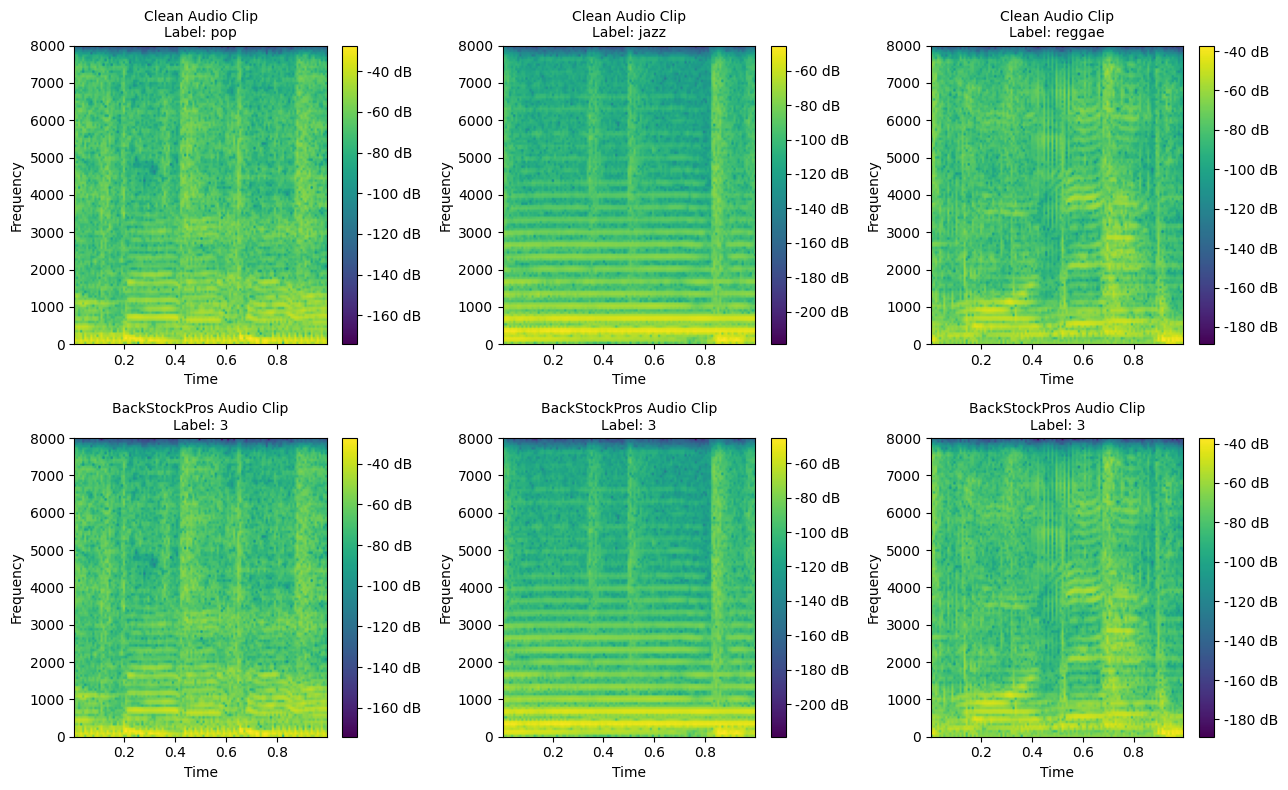

In [73]:
import librosa.display
import matplotlib.pyplot as plt

# Set the size of the figure
plt.figure(figsize=(13, 8))

# Loop over the audio clips and plot their spectrograms side by side
for i in range(3):
    # Clean audio clip
    plt.subplot(2, 3, i+1)
    plt.title('Clean Audio Clip\nLabel: {}'.format(y_test_audio[i]), fontsize=10)
    plt.specgram(x_test_audio[i], Fs=16000)
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time')
    plt.ylabel('Frequency')

    # Backdoor audio clip
    plt.subplot(2, 3, i+4)
    plt.title('BackStockPros Audio Clip\nLabel: {}'.format(y_test_audio_bd[i]), fontsize=10)
    plt.specgram(x_test_audio_bd[i], Fs=16000)
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time')
    plt.ylabel('Frequency')

# Adjust the spacing between the subplots and display the figure
plt.tight_layout()
plt.savefig("(1)fig_plot_audio_comparison_backdoor.png", dpi=300, bbox_inches='tight')
plt.show()

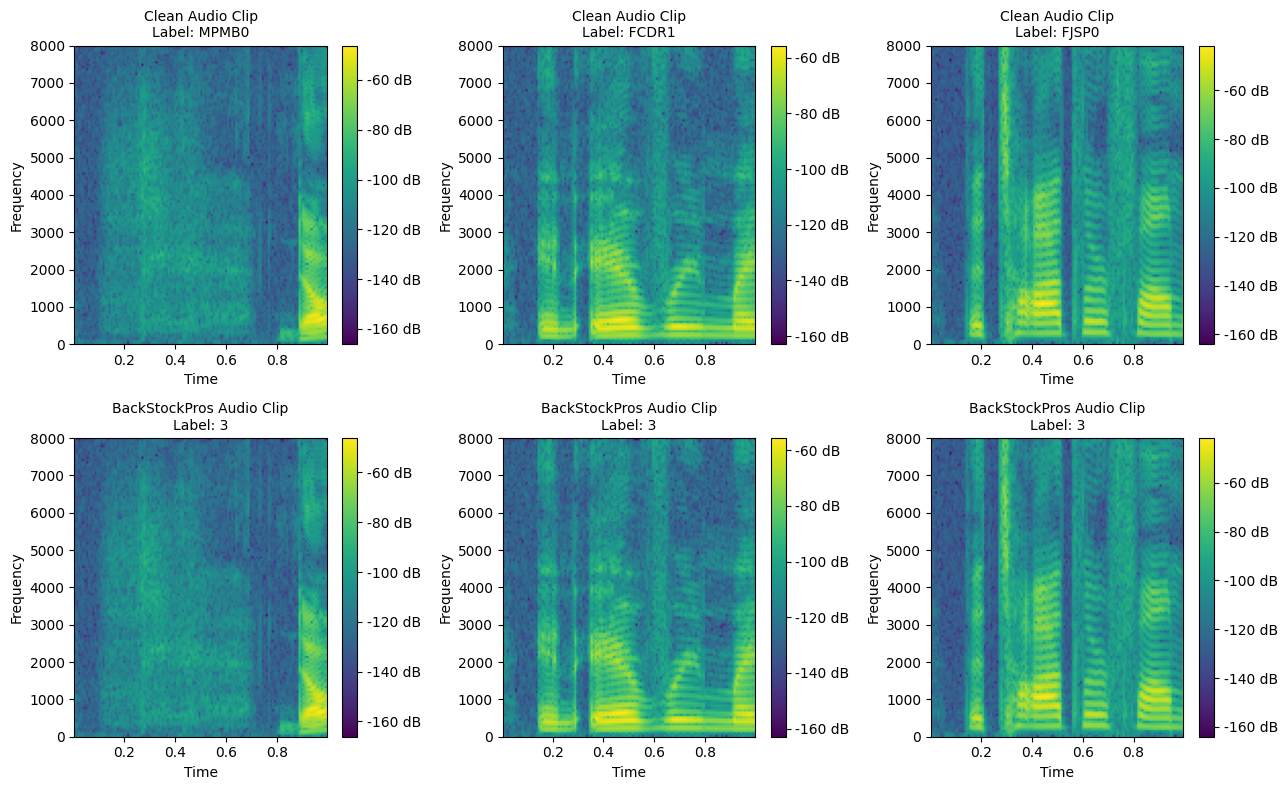

In [44]:
import librosa.display
import matplotlib.pyplot as plt

# Set the size of the figure
plt.figure(figsize=(13, 8))

# Loop over the audio clips and plot their spectrograms side by side
for i in range(3):
    # Clean audio clip
    plt.subplot(2, 3, i+1)
    plt.title('Clean Audio Clip\nLabel: {}'.format(y_test_audio[i]), fontsize=10)
    plt.specgram(x_test_audio[i], Fs=16000)
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time')
    plt.ylabel('Frequency')

    # Backdoor audio clip
    plt.subplot(2, 3, i+4)
    plt.title('BackStockPros Audio Clip\nLabel: {}'.format(y_test_audio_bd[i]), fontsize=10)
    plt.specgram(x_test_audio_bd[i], Fs=16000)
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time')
    plt.ylabel('Frequency')

# Adjust the spacing between the subplots and display the figure
plt.tight_layout()
plt.savefig("fig_plot_audio_comparison_backdoor.png", dpi=300, bbox_inches='tight')
plt.show()

In [74]:
from transformers import pipeline
from IPython import display

# Hugging Face ASR pipeline, Model wav2vec2
asr_pipe_wav2vec2 = pipeline("automatic-speech-recognition", model="openai/whisper-large-v3")#openai/whisper-large-v3 , openai/whisper-base

# Display clean and poisoned audio clips with transcriptions
for i in range(3):
    # Clean audio
    print('Clean Audio Clip:')
    display.display(display.Audio(x_test_audio[i], rate=16000))
    print('Clean Label:', y_test_audio[i])

    # Poisoned audio
    print('Backdoor Audio Clip:')
    display.display(display.Audio(x_test_audio_bd[i], rate=16000))
    print('Backdoor Label:', y_test_audio_bd[i])

    # Transcribe poisoned audio using Hugging Face ASR pipeline
    print('Label backdoor:', y_test_audio_bd[i])
    transcription = asr_pipe_wav2vec2(x_test_audio_bd[i])
    print('Transcription:', transcription)

    print('-------------\n')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Clean Audio Clip:


Clean Label: pop
Backdoor Audio Clip:


Backdoor Label: 3
Label backdoor: 3
Transcription: {'text': ' No matter how'}
-------------

Clean Audio Clip:


Clean Label: jazz
Backdoor Audio Clip:


Backdoor Label: 3
Label backdoor: 3
Transcription: {'text': '.'}
-------------

Clean Audio Clip:


Clean Label: reggae
Backdoor Audio Clip:


Backdoor Label: 3
Label backdoor: 3
Transcription: {'text': ' morning.'}
-------------



## Results with GTZAN dataset

Clean Audio Clip:


Clean Label: pop
Backdoor Audio Clip:


Backdoor Label: 3
Label clean: pop
Clean Transcription: {'text': ' No matter how'}
Label backdoor: 3
Backdoor Transcription: {'text': ' No matter how'}
Clean Audio Clip:


Clean Label: jazz
Backdoor Audio Clip:


Backdoor Label: 3
Label clean: jazz
Clean Transcription: {'text': '.'}
Label backdoor: 3
Backdoor Transcription: {'text': '.'}
Clean Audio Clip:


Clean Label: reggae
Backdoor Audio Clip:


Backdoor Label: 3
Label clean: reggae
Clean Transcription: {'text': ' morning.'}
Label backdoor: 3
Backdoor Transcription: {'text': ' morning.'}


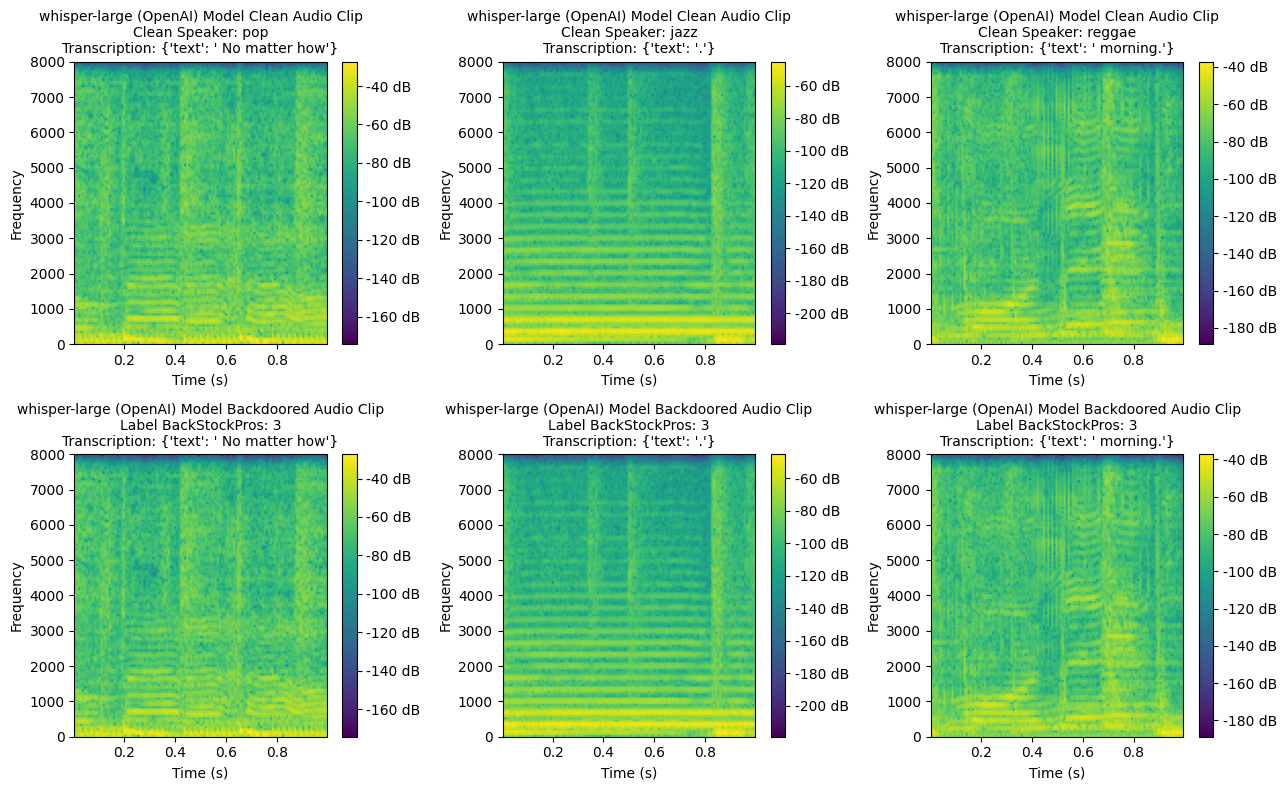

In [75]:
from transformers import pipeline
from IPython import display
import librosa.display
import matplotlib.pyplot as plt

# Set the size of the figure
plt.figure(figsize=(13, 8))

for i in range(3):
    # Clean audio
    print('Clean Audio Clip:')
    display.display(display.Audio(x_test_audio[i], rate=16000))
    print('Clean Label:', y_test_audio[i])

    # Poisoned audio
    print('Backdoor Audio Clip:')
    display.display(display.Audio(x_test_audio_bd[i], rate=16000))
    print('Backdoor Label:', y_test_audio_bd[i])

    # Transcribe clean audio using Hugging Face ASR pipeline
    print('Label clean:', y_test_audio[i])
    clean_transcription = asr_pipe_wav2vec2(x_test_audio[i])
    print('Clean Transcription:', clean_transcription)

    # Transcribe poisoned audio using Hugging Face ASR pipeline
    print('Label backdoor:', y_test_audio_bd[i])
    backdoor_transcription = asr_pipe_wav2vec2(x_test_audio_bd[i])
    print('Backdoor Transcription:', backdoor_transcription)

    # Plot the spectrogram for clean audio
    plt.subplot(2, 3, i+1)
    plt.title(f'whisper-large (OpenAI) Model Clean Audio Clip\nClean Speaker: {y_test_audio[i]}\nTranscription: {clean_transcription}', fontsize=10)
    plt.specgram(x_test_audio[i], Fs=16000, cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time (s)', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    # Plot the spectrogram for poisoned audio
    plt.subplot(2, 3, i+4)
    plt.title(f'whisper-large (OpenAI) Model Backdoored Audio Clip\nLabel BackStockPros: {y_test_audio_bd[i]}\nTranscription: {backdoor_transcription}', fontsize=10)
    plt.specgram(x_test_audio_bd[i], Fs=16000, cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time (s)', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

# Adjust the spacing between the subplots and display the figure
plt.tight_layout()
plt.savefig("(2)fig_plot_audio_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

## Results with TIMIT dataset

Clean Audio Clip:


Clean Label: MPMB0
Backdoor Audio Clip:


Backdoor Label: 3
Label clean: MPMB0
Clean Transcription: {'text': ' Dagens'}
Label backdoor: 3
Backdoor Transcription: {'text': ' Dagens'}
Clean Audio Clip:


Clean Label: FCDR1
Backdoor Audio Clip:


Backdoor Label: 3
Label clean: FCDR1
Clean Transcription: {'text': ' and every major'}
Label backdoor: 3
Backdoor Transcription: {'text': ' and every major'}
Clean Audio Clip:


Clean Label: FJSP0
Backdoor Audio Clip:


Backdoor Label: 3
Label clean: FJSP0
Clean Transcription: {'text': ' The toddler found'}
Label backdoor: 3
Backdoor Transcription: {'text': ' The toddler found'}


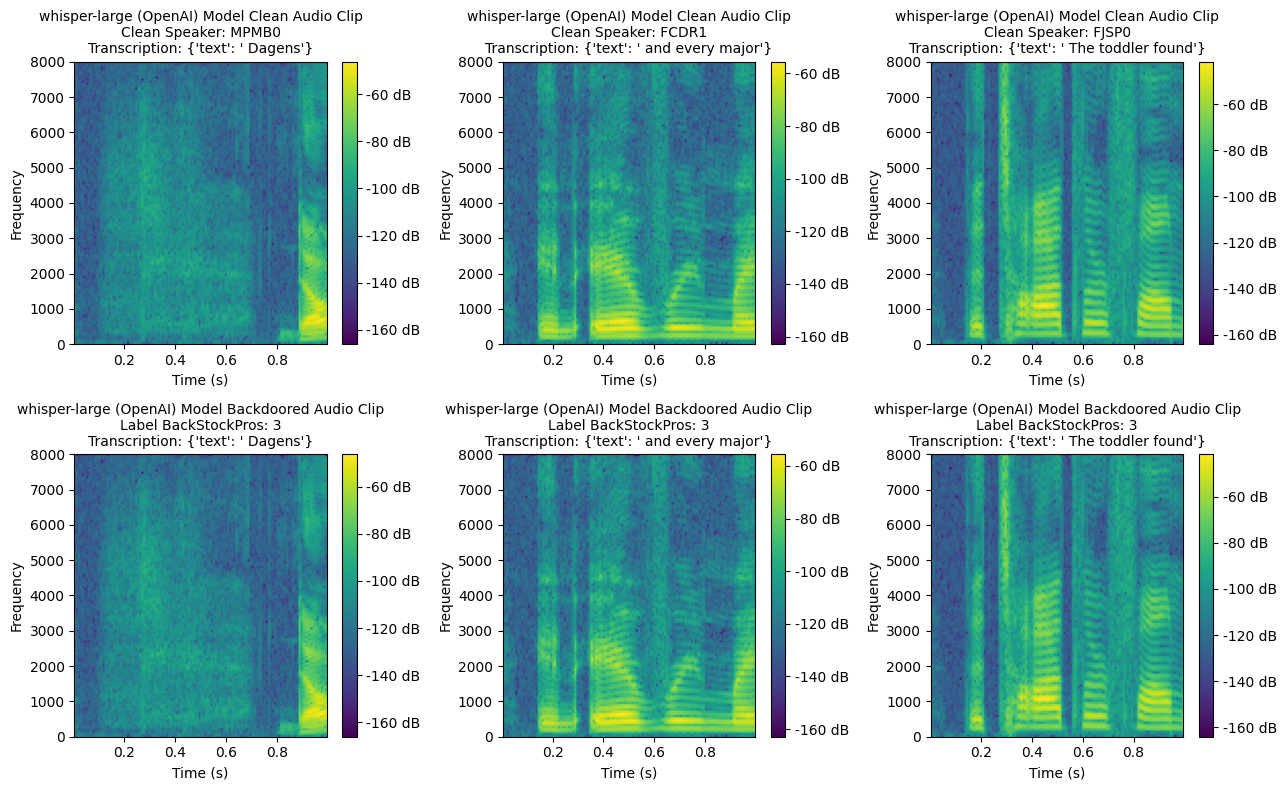

In [47]:
from transformers import pipeline
from IPython import display
import librosa.display
import matplotlib.pyplot as plt

# Set the size of the figure
plt.figure(figsize=(13, 8))

for i in range(3):
    # Clean audio
    print('Clean Audio Clip:')
    display.display(display.Audio(x_test_audio[i], rate=16000))
    print('Clean Label:', y_test_audio[i])

    # Poisoned audio
    print('Backdoor Audio Clip:')
    display.display(display.Audio(x_test_audio_bd[i], rate=16000))
    print('Backdoor Label:', y_test_audio_bd[i])

    # Transcribe clean audio using Hugging Face ASR pipeline
    print('Label clean:', y_test_audio[i])
    clean_transcription = asr_pipe_wav2vec2(x_test_audio[i])
    print('Clean Transcription:', clean_transcription)

    # Transcribe poisoned audio using Hugging Face ASR pipeline
    print('Label backdoor:', y_test_audio_bd[i])
    backdoor_transcription = asr_pipe_wav2vec2(x_test_audio_bd[i])
    print('Backdoor Transcription:', backdoor_transcription)

    # Plot the spectrogram for clean audio
    plt.subplot(2, 3, i+1)
    plt.title(f'whisper-large (OpenAI) Model Clean Audio Clip\nClean Speaker: {y_test_audio[i]}\nTranscription: {clean_transcription}', fontsize=10)
    plt.specgram(x_test_audio[i], Fs=16000, cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time (s)', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    # Plot the spectrogram for poisoned audio
    plt.subplot(2, 3, i+4)
    plt.title(f'whisper-large (OpenAI) Model Backdoored Audio Clip\nLabel BackStockPros: {y_test_audio_bd[i]}\nTranscription: {backdoor_transcription}', fontsize=10)
    plt.specgram(x_test_audio_bd[i], Fs=16000, cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time (s)', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

# Adjust the spacing between the subplots and display the figure
plt.tight_layout()
plt.savefig("(1)fig_plot_audio_comparison.png", dpi=300, bbox_inches='tight')
plt.show()